In [1]:
# Here, we import libraries that we want to use
import csv
import numpy as np
# For random numbers
from numpy.random import default_rng
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
from matplotlib.colors import ListedColormap
import matplotlib.transforms as mtransforms

In [18]:
# F U N C T I O N S
def csvToArray(filePath):
    # Load data from a csv into a list of dicts
    data = []
    with open(filePath, 'r') as f:
        dictReader = csv.DictReader(f)
        data = list(dictReader)
    return data

def makeValuesFloat(data, fieldsToModify):
    # Modify fields in fieldsToModify so that they are flots
    for el in data:
        for field in fieldsToModify:
            el[field] = float(el[field])
    return data

def bulkAddField(data, fieldToAdd, defaultValue):
    # Add a field to each element in data
    for el in data:
        el.update({ fieldToAdd : defaultValue })
    return data

def findNaNVals(data, toSearch, toAppend):
    # Check to see if any entries are NaN and report which ones are
    containNaNs = []
    for el in data:
        if np.isnan(el[toSearch]):
            if not el[toAppend] in containNaNs:
                containNaNs.append(el[toAppend])
    return containNaNs

def propagateErrors(data, fieldToExamine, errorMultiplier, fieldToAdd):
    # Here, we add new fields to each datum (fieldToAdd) + min or + max value
    # Alternatively, we might ask for a max and a min multiplier (TODO)
    for el in data:
        value = el[fieldToExamine]
        el.update({fieldToAdd+'Min' : value * (1 - errorMultiplier)})
        el.update({fieldToAdd+'Max' : value * (1 + errorMultiplier)})
    return data

def groupBy(var, data, group):
    # var is an array containing vals for the grouping variable
    # data is an array containing the data we would like to group (of the same length as var)
    # group is an array that contains all unique group values
    output = []
    for item in group:
        # Need a better way to reference multiple columns
        if len(data.shape) > 1:
            thisGroup = data[np.where(var == item), :]
        else:
            thisGroup = data[np.where(var == item)]
        output.append(thisGroup.flatten())
    return output

def groupStats(data, kind):
    # Here, we produce stats for each list in a list
    if kind == 'mean':
        output = list(map(lambda x: np.round(np.mean(x), 0), data))
    elif kind == 'median':
        output = list(map(lambda x: np.round(np.median(x), 0), data))
    else:
        output = data
    return output

def clusterByPeriod(data, resampledMeasurements, periods):
    # We would like to cluster data
    # Output lists
    ooidsByPeriod = []
    numFormations = []
    numLocations = []
    locationNames = []
    # For each period in periods
    for period in periods:
        # Which ooids come from this period?
        validIdxs = [idx for idx, el in enumerate(data) if el['period'] == period]
        # Collect all of the measurements (note that these are resampled and are linked to the data (list of dicts) by row order!)
        if len(np.shape(resampledMeasurements)) > 1:
            theseMeasurements = resampledMeasurements[validIdxs, :]
        else:
            theseMeasurements = resampledMeasurements[validIdxs]
         # How many formations?
        formationCount = len(set([ooidsData[idx]['formation'] for idx in validIdxs]))
        # How many unique _locations_?
        uniqueLocs = set([ooidsData[idx]['location'] for idx in validIdxs])
        locationCount = len(uniqueLocs)
        # Append
        ooidsByPeriod.append(theseMeasurements.flatten())
        numFormations.append(formationCount)
        numLocations.append(locationCount)
        locationNames.append(list(uniqueLocs))
    return ooidsByPeriod, numFormations, numLocations, locationNames

def commonBoxPlot(data, positions, whichAxis):
    plt.figure(figsize = (12, 4), dpi = 300)
    plt.xticks(rotation = 90)
    plt.yscale('log')
    plt.boxplot(data, positions=positions, patch_artist = True,
        boxprops = dict(facecolor = 'white', color = 'black'), 
        widths = 5, flierprops = {'marker': 'o', 'markersize': 2, 'markeredgecolor': 'grey'})
    commonParameters(plt.gca(), whichAxis)
    plt.ylim(10, 50000)
    plt.title('\\textit{Ooid size through time}')

def violinPlot(data, grouping, uniquePeriods, statVals, widths):
    fig, ax = plt.subplots(figsize = (6.5, 3), dpi = 300)
    labels = []
    for itr, el in enumerate(uniquePeriods):
        violin = ax.violinplot(data[itr], [grouping[itr]], showmeans=False, showmedians=False,
            showextrema=False, widths = widths)
        violin["bodies"][0].set_facecolor(colormap(itr/len(uniquePeriods)))
        violin["bodies"][0].set_edgecolor(colormap(itr/len(uniquePeriods)))
        color = violin["bodies"][0].get_facecolor().flatten()
        labels.append((mpatches.Patch(color=color), el))
        ax.scatter(grouping[itr], statVals[itr], fc='white', ec=color, s=10)
    legend= plt.legend(*zip(*labels), loc='upper left', bbox_to_anchor=(1.025, 1.01))
    legendFrame = legend.get_frame()
    legendFrame.set_linewidth(0.5)
    legendFrame.set_edgecolor('black')
    legendFrame.set_boxstyle('square')
    ax.grid(True, which = 'major', color = 'grey', linewidth = .25, axis = 'y')
    return ax

def commonParameters(ax, whichAxis):
    ax.grid(True, which = 'minor', axis = 'y', color='grey', linewidth=.125, linestyle=':')
    ax.grid(True, which = 'major', color = 'grey', linewidth = .25, axis = 'y')
    ax.invert_xaxis()
    ax.set_axisbelow(True)
    ax.set_ylim(100, 1100)
    ax.set_xlim(550, 0)
    ax.set_ylabel(whichAxis.replace('_', ' ').capitalize() + ' length ($\mu$m)')
    ax.set_xlabel('Time (Ma)')
    plt.tight_layout(pad=0) # Adjust the spacing of the subplots

def createNPArray(data, fieldsToUse):
    # Create an NP array where each column is one element from fieldsToUse
    fullList = []
    for el in data:
        toAppend = []
        for field in fieldsToUse:
            toAppend.append(el[field])
        fullList.append(toAppend)
    outputArray = np.asarray(fullList)
    return outputArray

def findCorrespondingPeriodIdx(refTop, refBottom, thisTop, thisBottom):
    meetsTop = np.argwhere(thisTop >= refTop)
    meetsBottom = np.argwhere(thisBottom <= refBottom)
    whichIdx = np.intersect1d(meetsTop, meetsBottom)
    return whichIdx

def reProportion(targetValues, datasetValues):
    # Re-proportioning
    targetProportions = targetValues / np.sum(targetValues)
    # We set up a count of under-represented periods. The idea is, we cannot make up new locations, but we _can_ randomly remove them from our dataset. Our goal is to minimize this count.
    countOfUnder = len(datasetValues)
    gettingBetter = True
    updatedValues = np.asarray(datasetValues)
    updatedProportions = datasetValues / np.sum(datasetValues)
    while gettingBetter:
        # What is the difference between the dataset proportions and the toMatch proportions?
        diff = updatedProportions - targetProportions
        # Now, what is the minimum residual (as that represents a period where we have much fewer locations than expected)?
        largestResidualIdx = np.argmin(diff)
        # This idx becomes our datum: every other period will be adjusted to match
        # How many total locations would be in our dataset given this updated datum?
        proposedSumValues = updatedValues[largestResidualIdx] / targetProportions[largestResidualIdx]
        # Given this updated total, how many locations would be in each period?
        proposedValues = np.rint(targetProportions * proposedSumValues)
        # Now, let's go through this proposed count and do two things:
        # 1st: Any 0 values must be set to 1 (we need at least one location for each time period)
        # 2nd: If the proposed locations are greater than exist in updatedLocationCounts, set that value to the corresponding one in updatedLocationCounts and add one to the undercount counter
        thisUnderCount = 0
        for itr, val in enumerate(proposedValues):
            if val == 0:
                proposedValues[itr] = 1
            if val > updatedValues[itr]:
                proposedValues[itr] = updatedValues[itr]
                thisUnderCount = thisUnderCount + 1
        if thisUnderCount < countOfUnder:
            countOfUnder = thisUnderCount
            updatedValues = proposedValues
            updatedProportions = updatedValues / np.sum(updatedValues)
            gettingBetter = True
        else:
            gettingBetter = False

    return({"locations" : updatedValues, "proportions" : updatedProportions, "targetProportions" : targetProportions})

def removeOutliersIQR(data):
    # Remove outliers by considering IQR
    outputData = []
    for ele in data:
        q1 = np.quantile(ele, 0.25)
        q3 = np.quantile(ele, 0.75)
        iqr = stats.iqr(ele)
        filteredData = ele[ (ele > q1-(1.5*iqr)) & (ele < q3+(1.5*iqr)) ]
        outputData.append(filteredData)
    return outputData

def returnRegressionStats(res):
    # What is the r^2?
    print(f"R-squared: {res.rvalue**2:.6f}")
    # What is the p value?
    print(f"p value: {res.pvalue:.6f}")

In [3]:
# C O M M O N 
# Font properties
fs = 10
plt.rcParams.update({
    'font.family': 'serif',

    'font.size': fs,
    'text.usetex': True
})
# Which colormap are we using?
# From Bolton
colors = [    [109, 26, 0], [211, 75, 0], [253, 102, 0], [255, 137, 40],
    [255, 169, 82], [255, 196, 124], [5, 94, 82], [44, 166, 134],
    [135, 186, 166], [1, 53, 112], [9, 103, 210], [84, 157, 241]
]

colormap = ListedColormap([(c[0]/255, c[1]/255, c[2]/255) for c in colors])

#colormap = mp.cm.get_cmap('tab20')


In [4]:
# L O A D  D A T A
# Begin by loading relevant data
ooidsDataPath = './ooidsDatabase.csv'
reportedValsPath = './table1KoeshidayatullahEtAl2022.csv'
# The data
ooidsData = csvToArray(ooidsDataPath)
# Make major_axis and minor_axis into floats
ooidsData = makeValuesFloat(ooidsData, ['major_axis', 'minor_axis'])
# How many ooids?
numOoids = len(ooidsData)
# Also load in the dataset published by Koeshidayatullah et al., 2022
reportedVals = csvToArray(reportedValsPath)
reportedVals = makeValuesFloat(reportedVals, ['Approx. age (Ma)'])

In [5]:
# A S S I G N  A G E S
# First, let us add a 'reportedAge' field
ooidsData = bulkAddField(ooidsData, 'reportedAge', np.nan)
# For each series/epoch in reportedVals, we find corresponding samples in ooidsData 
# For those corresponding samples, we update the 'reportedAge' field
for line in reportedVals:
    # This series/epoch
    thisSeries = line['Series/Epoch']
    # This age
    thisAge = line['Approx. age (Ma)']
    # Let's find which samples in ooidsData contain this string 
    # Can improve this implementation
    for element in ooidsData:
        # Is this string in the age string?
        if thisSeries in element['age']:
            # If so, set this age
            element.update({'reportedAge':thisAge})
# Check: are there any undefined ages?
findNaNVals(ooidsData, 'reportedAge', 'age');

In [6]:
# P R E P
# First, what is the global measurement error, in %?
measurementError = 0.20
# Which axis are we studying?
whichAxis = 'minor_axis'
whichAxisPrefix = 'minorAxis'

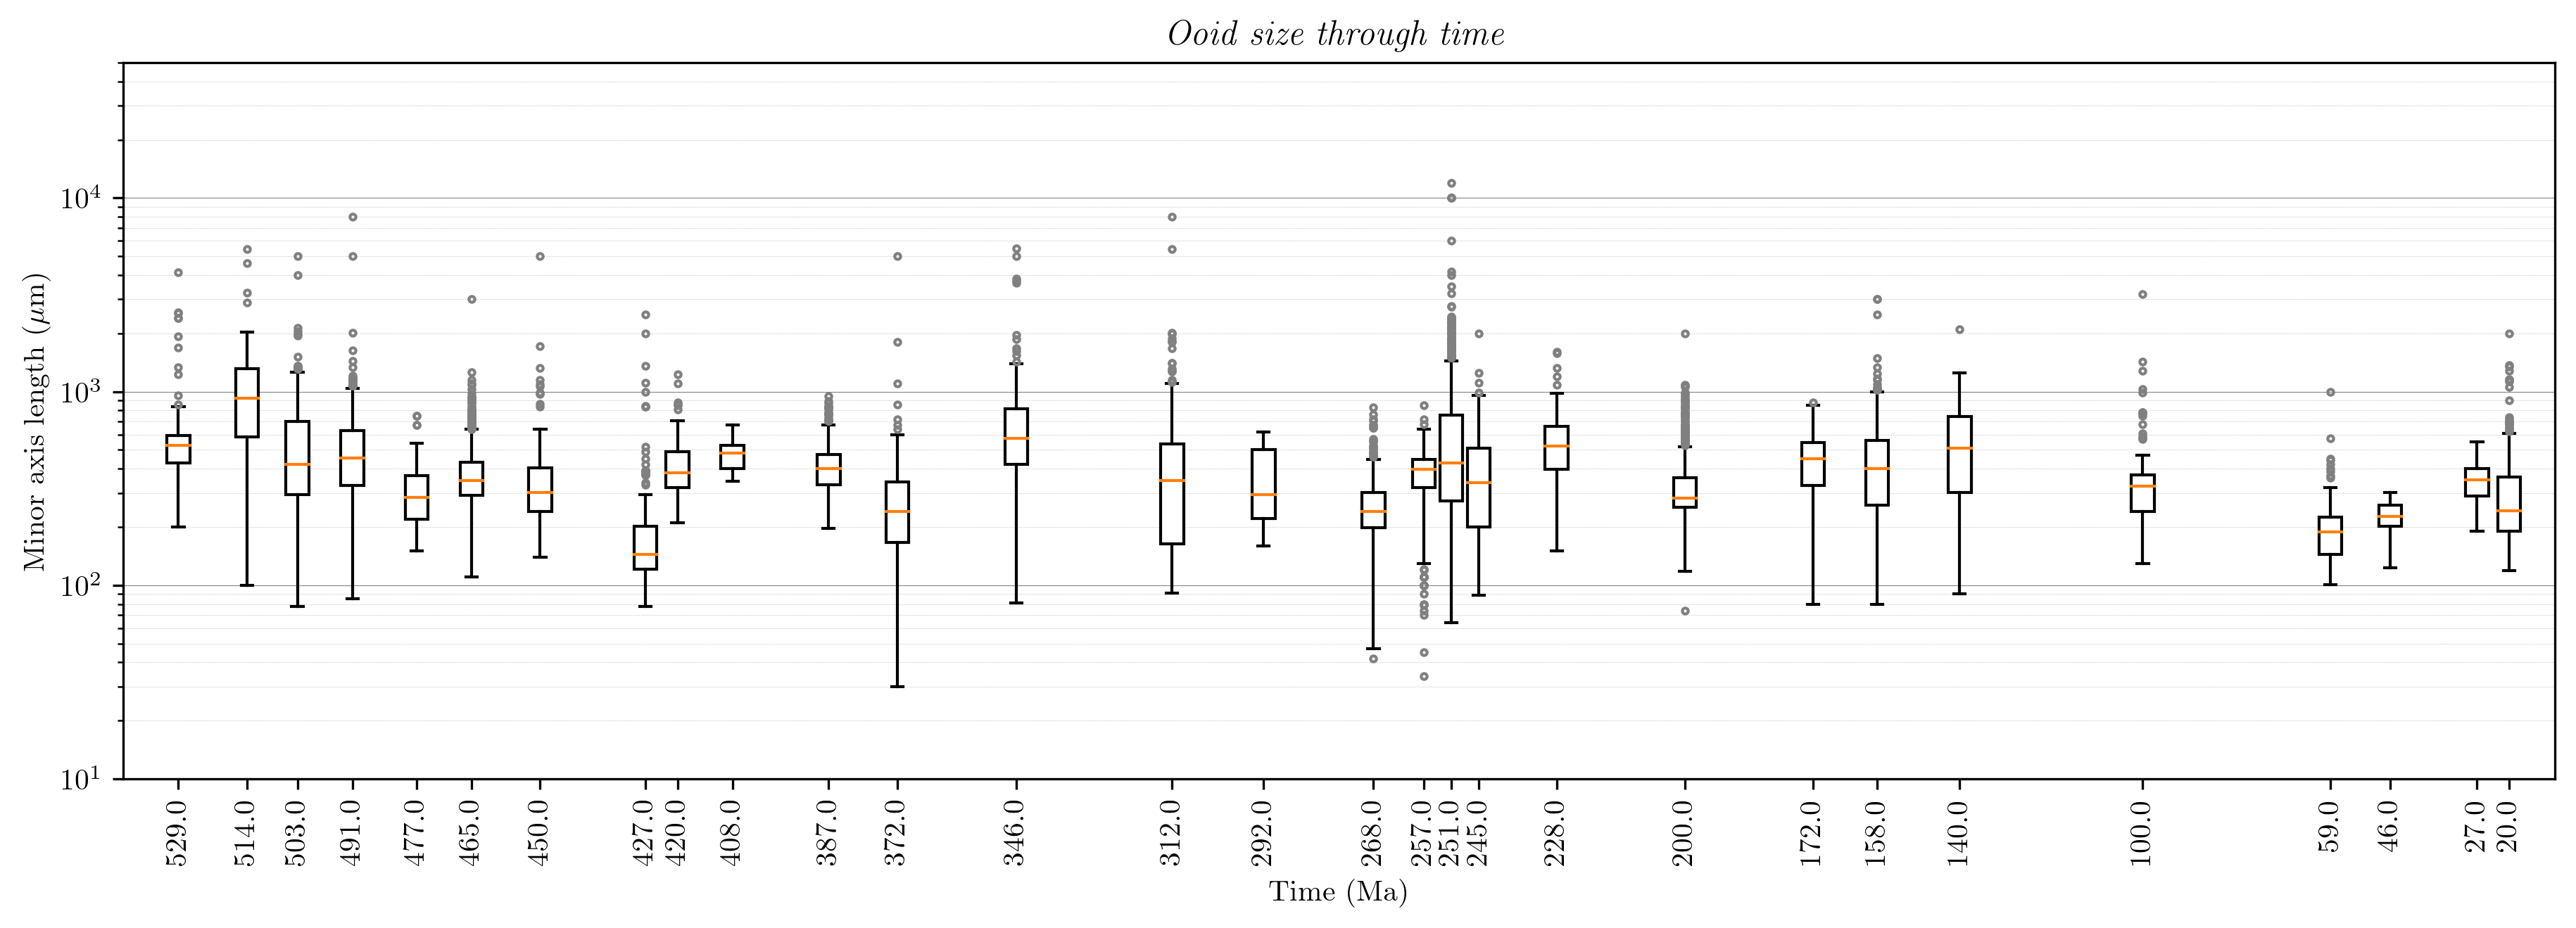

In [8]:
# C H E C K
# Now, let's recreate the boxplot in Fig. 2 of Koeshidayatullah et al., 2022
# Format the data first
# Unique reportedAge values
uniqueReportedAges = sorted(set(el['reportedAge'] for el in ooidsData))
# Group the published data using the unique reported ages
publishedPlotData = groupBy(np.asarray([el['reportedAge'] for el in ooidsData]), np.asarray([el[whichAxis] for el in ooidsData]), uniqueReportedAges)
# Plot it up!
commonBoxPlot(publishedPlotData, uniqueReportedAges, whichAxis)

Average aspect ratio is: 0.9007626973587042
Correlation coefficient is: 0.9789438781195439


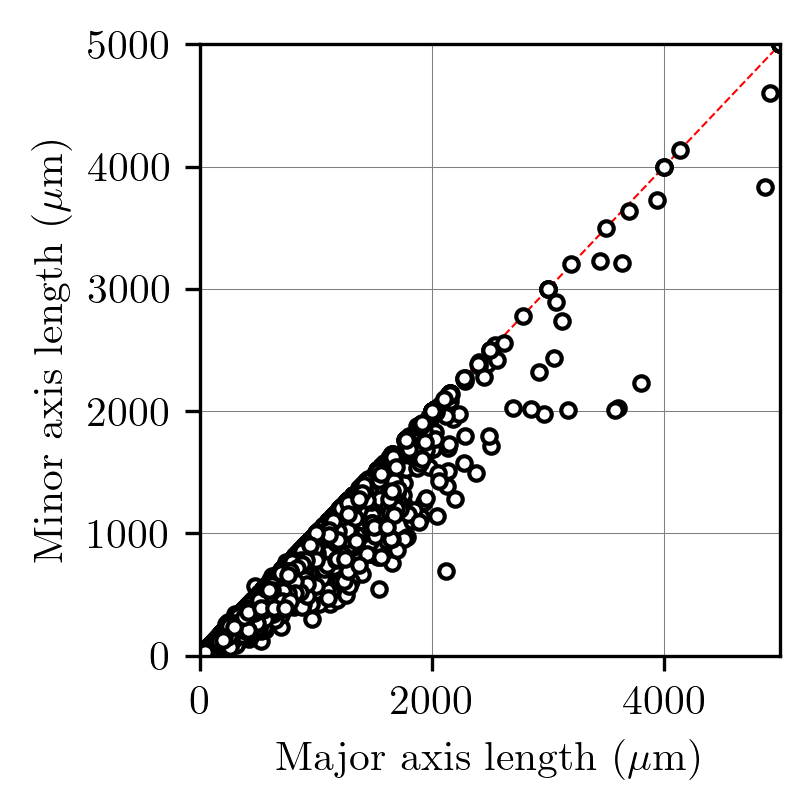

In [9]:
# E X P L O R I N G - T H E - O O I D S - D A T A S E T
# First, what are the aspect ratios of the measured ooids?
majorAxisVals = [el['major_axis'] for el in ooidsData]
minorAxisVals = [el['minor_axis'] for el in ooidsData]
aspectRatio = np.array(minorAxisVals) / np.array(majorAxisVals)
print('Average aspect ratio is: ' + str(np.mean(aspectRatio)))
print('Correlation coefficient is: ' + str(stats.pearsonr(majorAxisVals, minorAxisVals).statistic))
# Put together a scatter plot
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=300)
ax.plot(np.arange(0, 5000), np.arange(0, 5000), '--', color='red', linewidth=0.5, zorder=1)
ax.scatter(majorAxisVals, minorAxisVals, s=12, ec='black', fc='white', zorder=2)
ax.set_xlim(0, 5000)
ax.set_ylim(0, 5000)
ax.grid(True, which='major', color='grey', linewidth=.25, axis='both')
ax.set_axisbelow(True)
ax.set_ylabel('Minor axis length ($\mu$m)')
ax.set_xlabel('Major axis length ($\mu$m)')

plt.tight_layout(pad=0) # Adjust the spacing of the subplots

# Create layers and save!
fig.savefig('../figures/aspectRatio.pdf')

# Optional, set a title
#ax.set_title('\\textit{Major vs. minor axis lengths}');


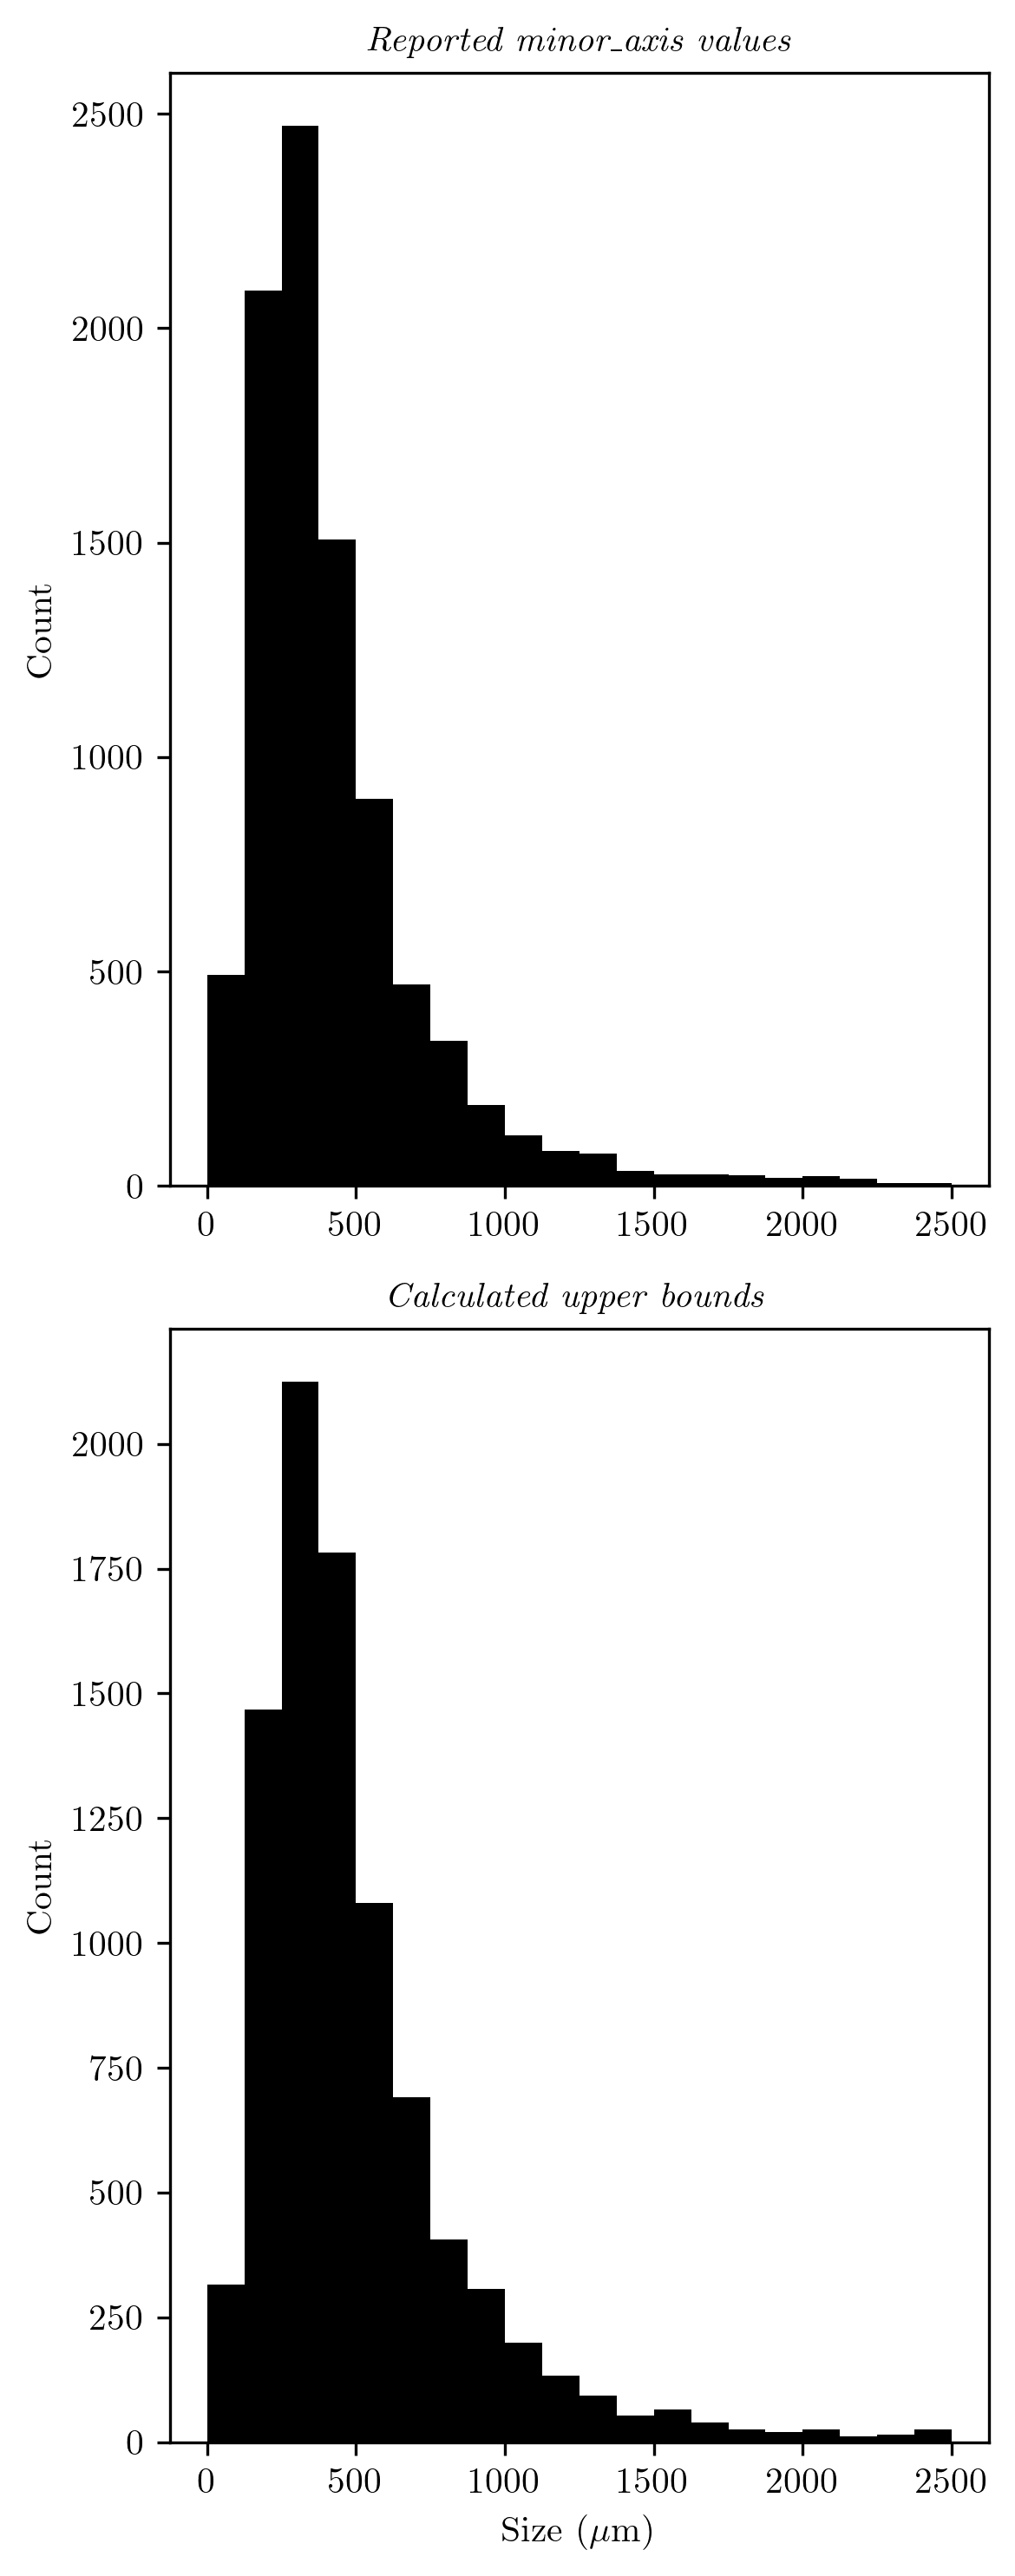

In [10]:
# E R R O R  B O U N D S
# Propagate that error!
ooidsData = propagateErrors(ooidsData, whichAxis, measurementError, whichAxisPrefix)
# Now, we plot up 2 histograms to demonstrate the upper bounds of size vs. the reported values
axisVals = [el[whichAxis] for el in ooidsData]
commonParams = dict(bins=20, range=(0, 2500), facecolor = 'black')
fig, axs = plt.subplots(2, 1, figsize = (4, 10), dpi = 300)
axs[0].hist(axisVals, **commonParams);
axs[0].set_title('\\textit{Reported ' + whichAxis + ' values}', fontsize = fs)
axs[0].set_ylabel('Count')
axs[1].hist([el[whichAxisPrefix+'Max'] for el in ooidsData], **commonParams)
axs[1].set_title('\\textit{Calculated upper bounds}', fontsize = fs)
axs[1].set_xlabel('Size ($\mu$m)')
axs[1].set_ylabel('Count')
fig.tight_layout()

In [16]:
# R E S A M P L I N G  P A R A M E T E R S
# Number of runs
numRuns = 1000
# Set up your random generator
rng = default_rng()

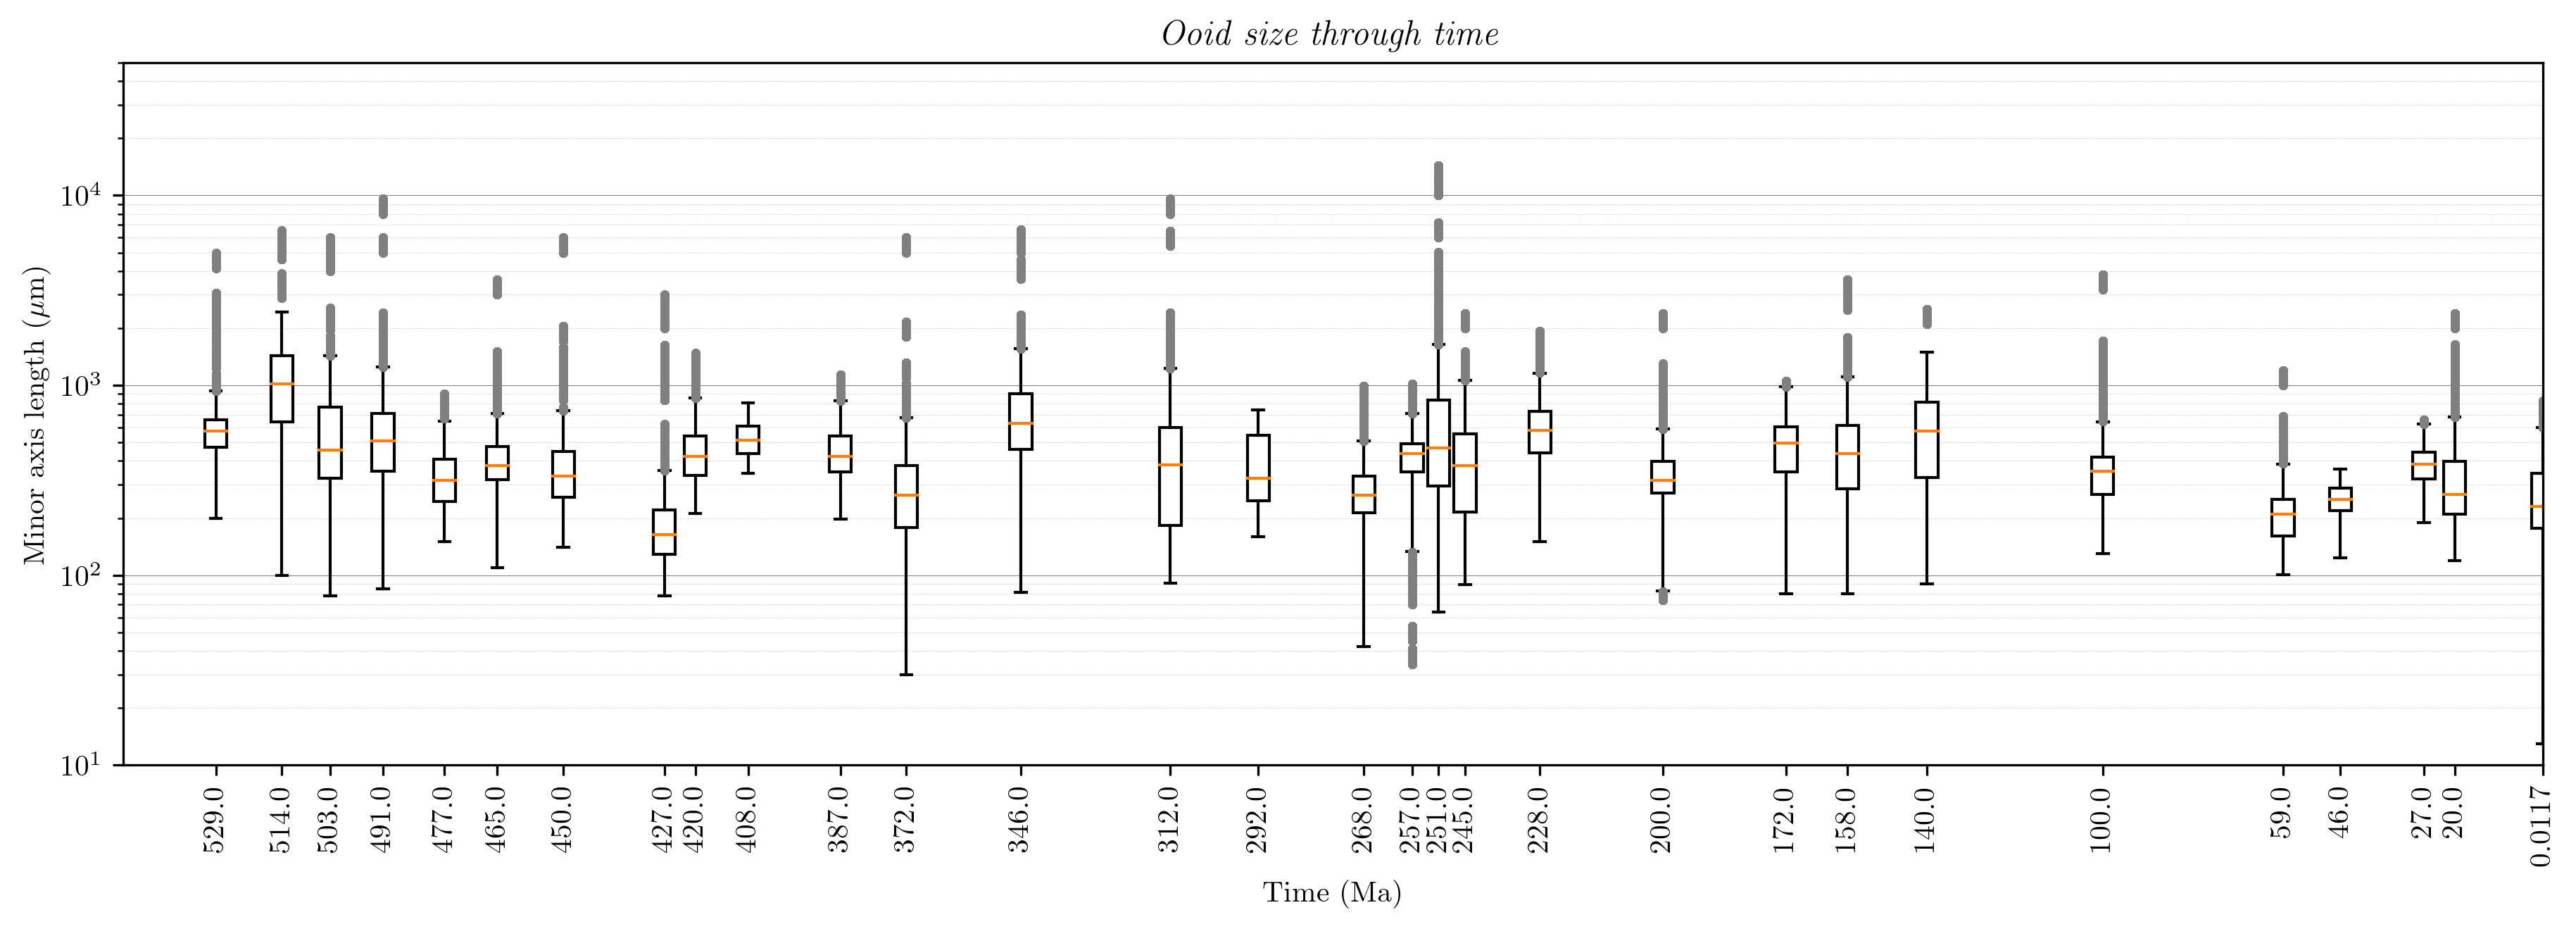

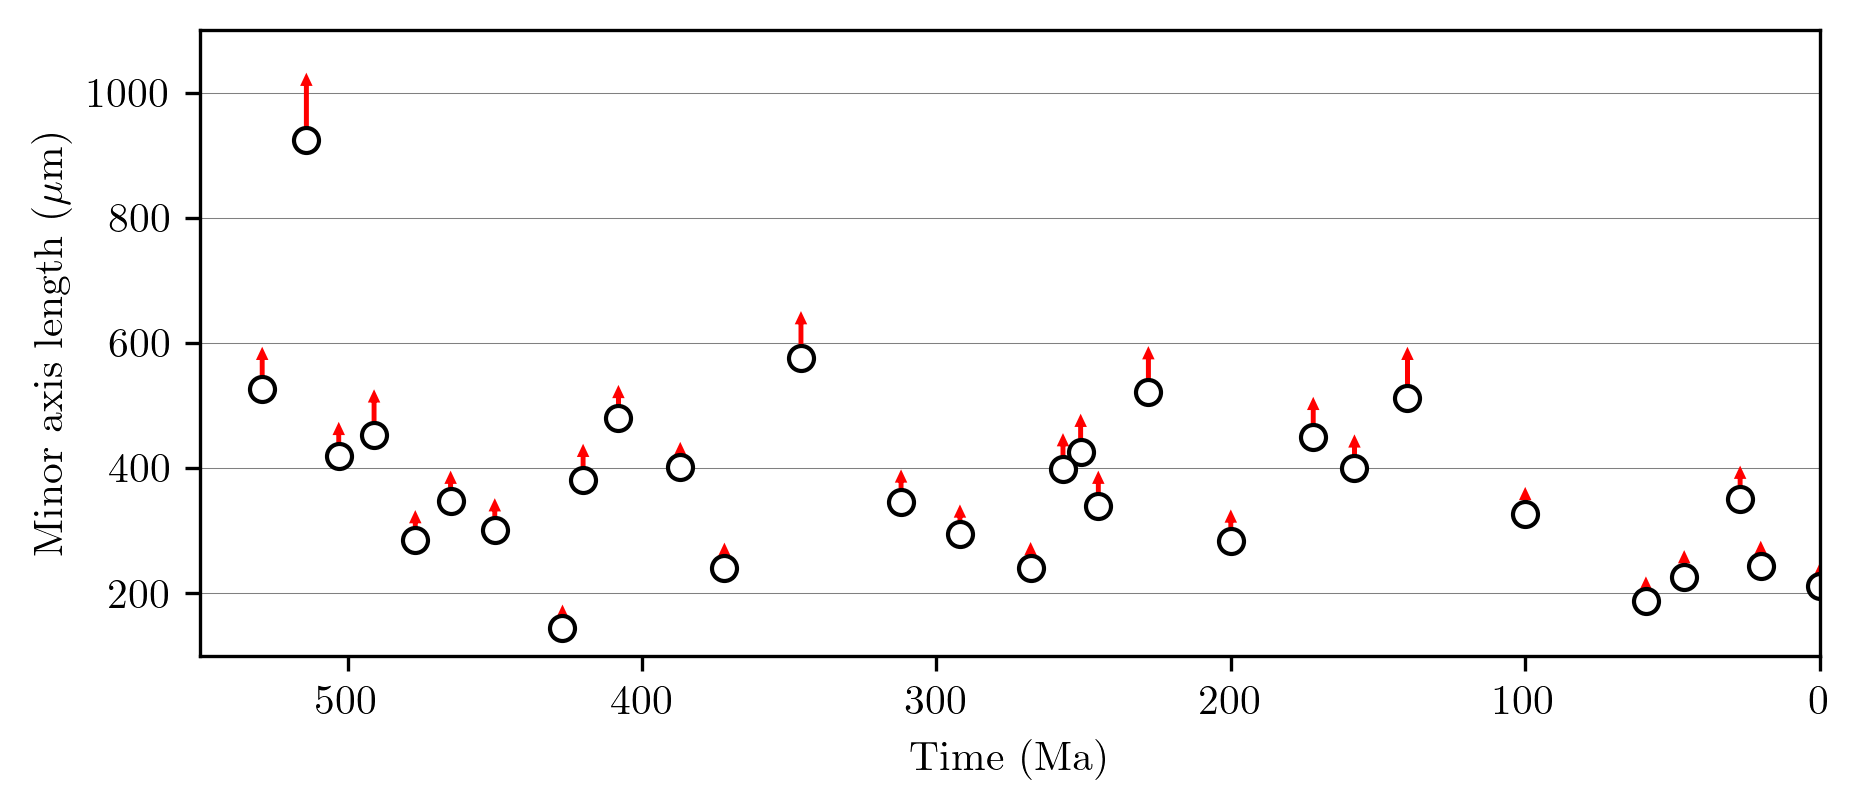

In [19]:
# S C E N A R I O # 1
# What happens if we try to recreate the box plot above but this time by resampling the data using the max values that we have calculated?
# First, a data collector, which has one row per ooid and one column per run
resampledOoidSizes = np.zeros([numOoids, numRuns])
# Next, create an np array of mxn where cols are: age, axisMin, and axisMax
toDrawFrom = createNPArray(ooidsData, ['reportedAge', whichAxis, whichAxisPrefix + 'Max'])
# Okay, now let's run things
for count in range(numRuns):
    # For each iteration, let us draw a new axis length for each ooid in the database
    # Note that the drawn values are rounded to the nearest whole number
    newAxis = np.round(rng.uniform(low = toDrawFrom[:, 1], high = toDrawFrom[:, 2]), 0)
    # Add these new values
    resampledOoidSizes[:, count] = newAxis
# Box plot the simulation output
# Group the data by time bin
simulatedData = groupBy(toDrawFrom[:,0], resampledOoidSizes, uniqueReportedAges);
commonBoxPlot(simulatedData, uniqueReportedAges, whichAxis)
# We also want to create an arrow plot that shows how the _median_ size per bin has changed
publishedMedians = groupStats(publishedPlotData, 'median')
simulatedMedians = groupStats(simulatedData, 'median')
change =  np.asarray(simulatedMedians) - np.asarray(publishedMedians)
fig, ax = plt.subplots(figsize = (6, 2.5), dpi = 300)
# Add arrows to plot
for itr, el in enumerate(publishedMedians):
    ax.arrow(uniqueReportedAges[itr], el, 0, change[itr], head_width=2, head_length=10, width=.25, ec='red') 
ax.scatter(uniqueReportedAges, publishedMedians, fc='white', ec='black')
#ax.set_title('\\textit{Change in median ooid size per time bin}')
commonParameters(ax, whichAxis)
fig.savefig('../figures/propagatedSize.pdf')

In [92]:
# O N - G E O L O G I C - P E R I O D S
# We begin by defining all Phanerozoic periods
uniquePeriods = ['Cambrian', 'Ordovician', 'Silurian', 'Devonian', 'Carboniferous', 'Permian', 'Triassic', 'Jurassic', 'Cretaceous', 'Paleogene', 'Neogene', 'Quaternary']
# Ensure that we don't have a period in our database that does not match our sorted list in uniquePeriods
notMatched = []
for el in list(set(item['period'] for item in ooidsData)):
    if not el in uniquePeriods:
        notMatched.append(el)
# If some period in our database is not in uniquePeriods, this statement should tell us:
if notMatched:
    print('Your list of geologic periods has fewer values than in the dataset!')
    raise

Original
R-squared: 0.283269
p value: 0.074867
Resampled
R-squared: 0.280229
p value: 0.076742


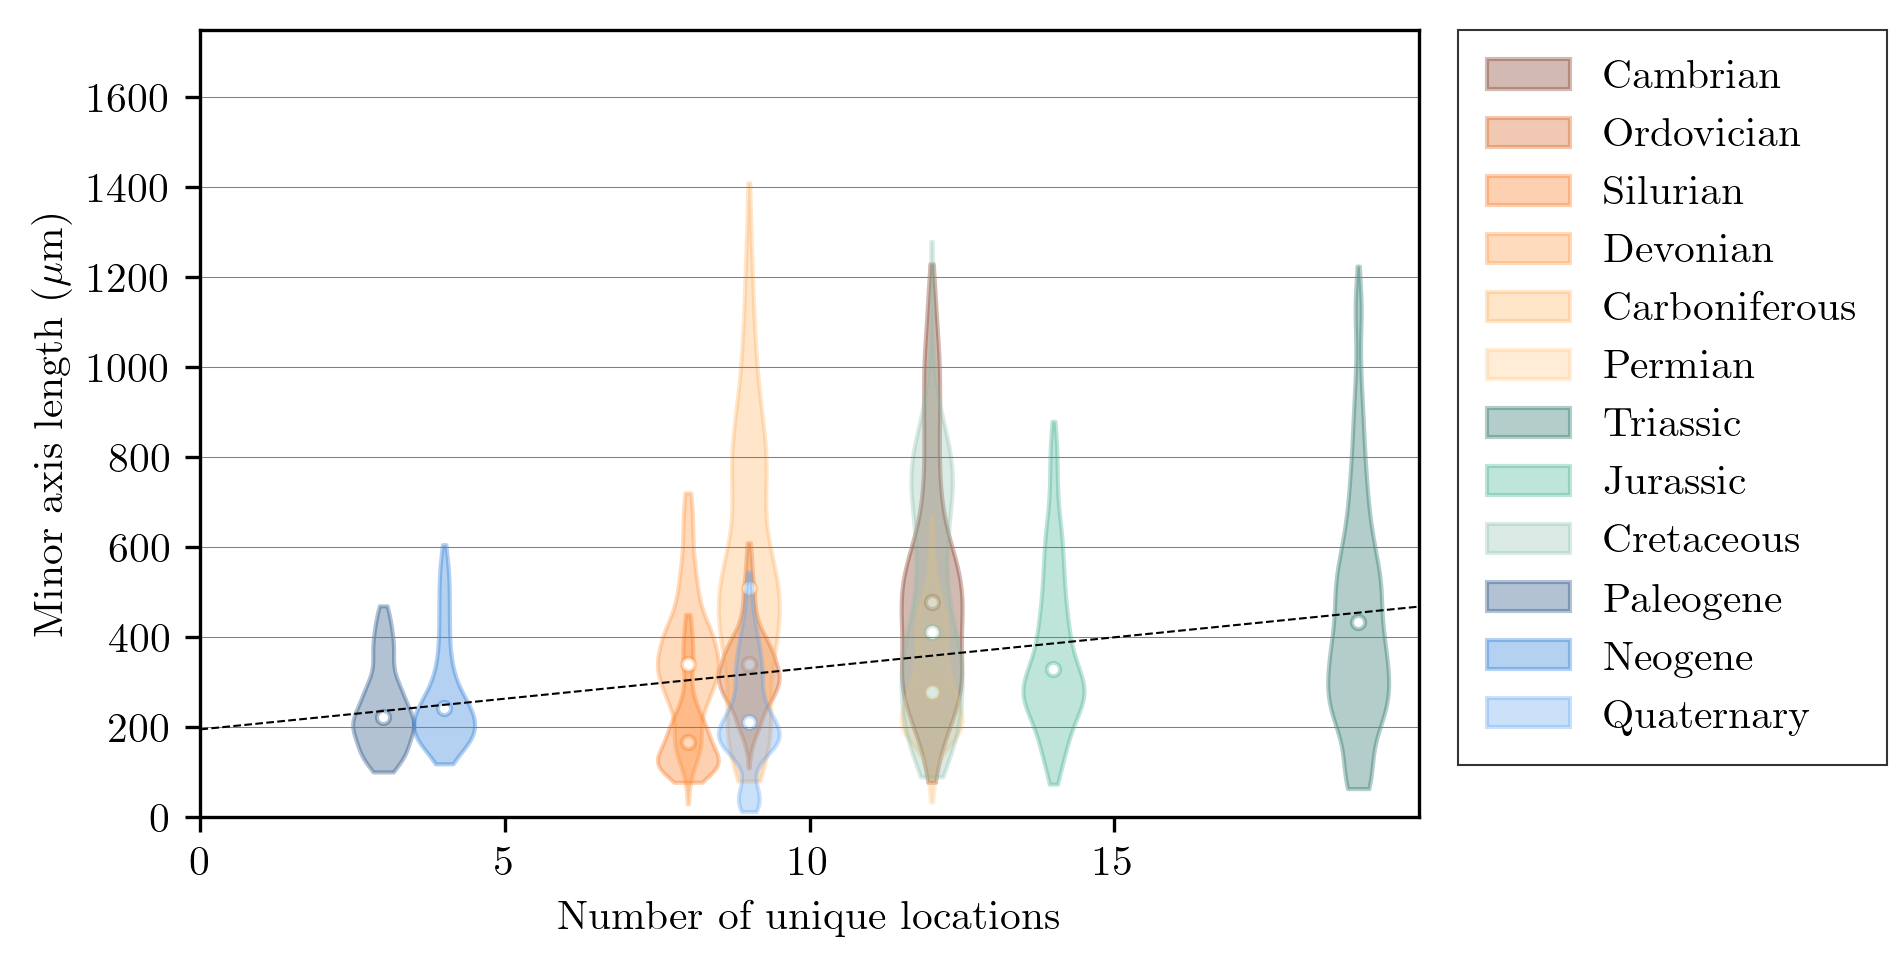

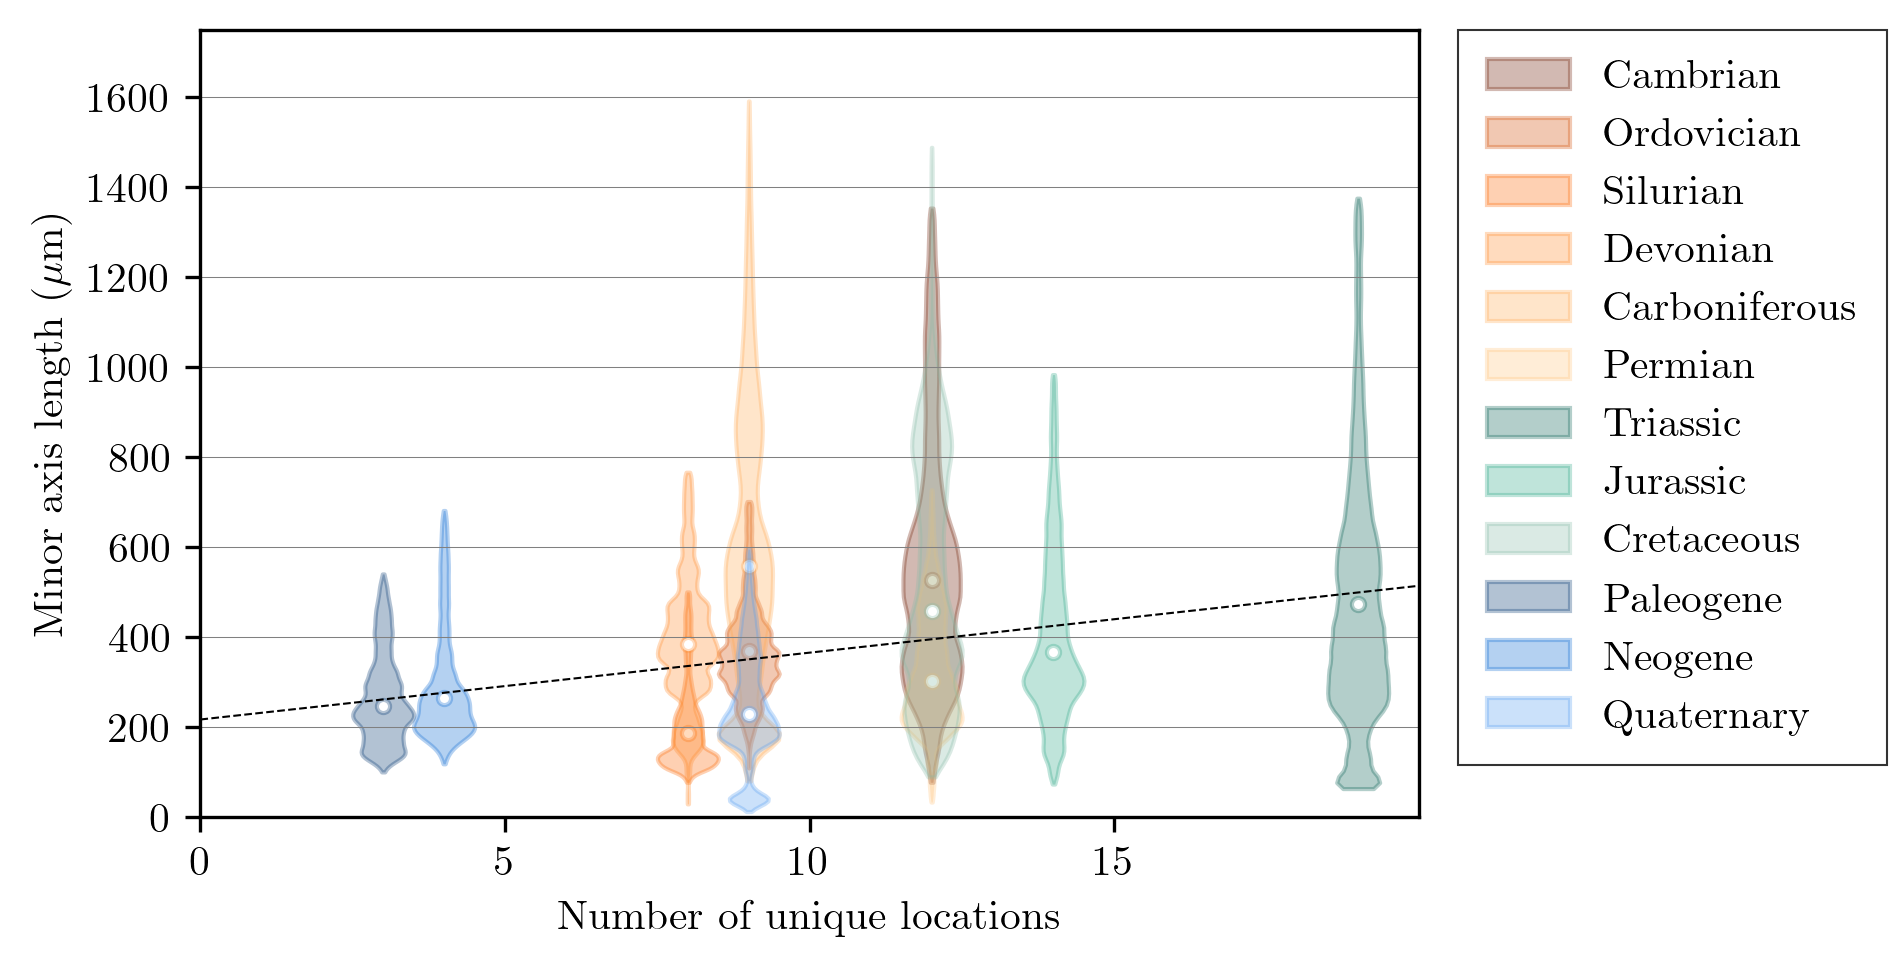

In [94]:
# S I Z E - P E R - P E R I O D
# What happens if cluster by period and then plot era statistics vs. formations per period?

# We want to work with two different kinds of data: pre and post resampling

sizesToCluster = [createNPArray(ooidsData, [whichAxis]), resampledOoidSizes]
clusterTitles = ['Original', 'Resampled']

for idx, itr in enumerate(sizesToCluster):
    print(clusterTitles[idx])
    # We cluster the resampled data by period
    ooidsByPeriod, numFormations, numLocations, locationNames = clusterByPeriod(ooidsData, itr, uniquePeriods)
    # Next, we get median values for each period
    periodMedians = list(map(np.median, ooidsByPeriod))
    # Finally, we plot
    # Note that we remove outliers using IQR
    ooidsMinusOutliers = removeOutliersIQR(ooidsByPeriod)
    thisAx = violinPlot(ooidsMinusOutliers, numLocations, uniquePeriods, periodMedians, 1)
    # thisAx.set_title('\\textit{Ooid size vs. number of occurrences---' + clusterTitles[idx] + '}')
    thisAx.set_xlim(0, 20)
    thisAx.set_xticks(np.arange(0, 20, 5))
    thisAx.set_ylim(0, 1750)
    thisAx.set_ylabel(whichAxis.replace('_', ' ').capitalize() + ' length ($\mu$m)')
    thisAx.set_xlabel('Number of unique locations')
    plt.tight_layout()
    plt.subplots_adjust(left=.125, bottom=.125, right=.75, top=1)
    # What about a super simple linear regression?
    resampledRegression = stats.linregress(numLocations, periodMedians)
    # Return the r^2 and p values for this regression
    returnRegressionStats(resampledRegression)
    # Plot this line
    locationArray = np.arange(100)
    thisAx.plot(locationArray, resampledRegression.intercept + resampledRegression.slope*locationArray, '--', color="black", linewidth=0.5, label='fitted line')
    # Save this plot
    plt.savefig('../figures/sizeVs' + clusterTitles[idx] + '.pdf')


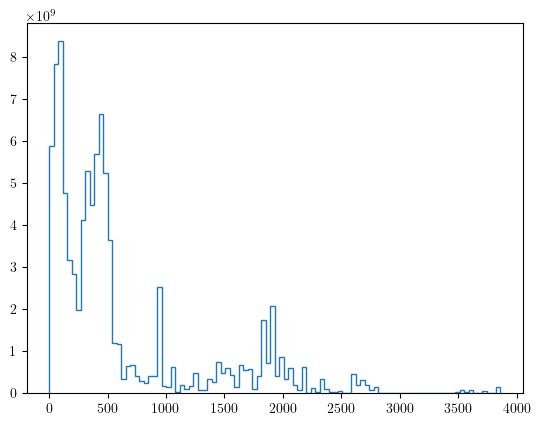

In [102]:
# P E R I O D - S P E C I F I C - S T A T S ( F O R - M A C R O S T R A T )
# We load in a .csv file that contains the name of each geologic period plus the age boundaries
# Note that GTS.csv comes from: https://github.com/japhir/GeologicTimeScale
GTS = csvToArray('GTS.csv')
# Critically, we only care about the geologic periods
GTSPeriods = [el for el in GTS if el['type'] == 'Period']
# Also, let us make the ages into floats
GTSPeriods = makeValuesFloat(GTSPeriods, ["top", "bot"])
# We get the top and bottom ages, as well as names, from GTSPeriods
GTSTopAges = np.asarray([el["top"] for el in GTSPeriods ])
GTSBottomAges = np.asarray([el["bot"] for el in GTSPeriods])
GTSPeriodNames = np.asarray([el["name"] for el in GTSPeriods])


# Next, we load in data from the macrostrat API response
macrostratData = csvToArray('macrostratQuery.csv')
# Make certain values into floats
macrostratData = makeValuesFloat(macrostratData, ["col_area", "max_thick", "min_thick", "t_age", "b_age"])
# Also, how many unique Macrostrat "columns" are there?
totalNumCols = len(set(int(el["col_id"]) for el in macrostratData))

# Now, we go through every entry in macrostratData and add geologic period fields
for el in macrostratData:
    # The top and bottom ages for this entry
    thisTopAge = el["t_age"]
    thisBottomAge = el["b_age"]
    # We calculate a mean age
    meanAge = (thisTopAge + thisBottomAge) / 2
    # And assign it to this element's dict
    el.update({"meanAge" : meanAge})
    # We also calculate the volume of rock for this element
    # Volume here is defined as area * the mean thickness of the column
    vol = el["col_area"] * ((el["max_thick"] + el["min_thick"]) / 2)
    # ...and, yet again, we update the dictionary
    el.update({"volume":vol})
    # Okay, finally, which period does this entry belong to?
    # We first check using the t_age and b_age provided by macrostrat
    el.update({"periodFromRange" : GTSPeriodNames[findCorrespondingPeriodIdx(GTSTopAges, GTSBottomAges, thisTopAge, thisBottomAge)]})
    # We also use our calculated "mean age"
    el.update({"periodFromMean" : GTSPeriodNames[findCorrespondingPeriodIdx(GTSTopAges, GTSBottomAges, meanAge, meanAge)]})
# Time to set up an output variable
msPerPeriodStats = []
# So, for each unique period
for period in uniquePeriods:
    # We first pull out the macrostrat entries from this period
    validEntries = [el for el in macrostratData if el['periodFromRange'].size > 0 and el['periodFromRange'] == period]
    # Now, let us get the number of unique column ids
    uniqueColCount = len(set(int(el["col_id"]) for el in validEntries))
    # Let us also get the total volume
    totalVolume = np.sum([el["volume"] for el in validEntries])
    msPerPeriodStats.append({"period" : period, "columnCount" : uniqueColCount, "totalVolume" : totalVolume})

# A quick histogram plot of volume through time
volStats = stats.binned_statistic([el["meanAge"] for el in macrostratData], [el["volume"] for el in macrostratData], 'sum', bins=100);
plt.stairs(volStats.statistic, volStats.bin_edges)



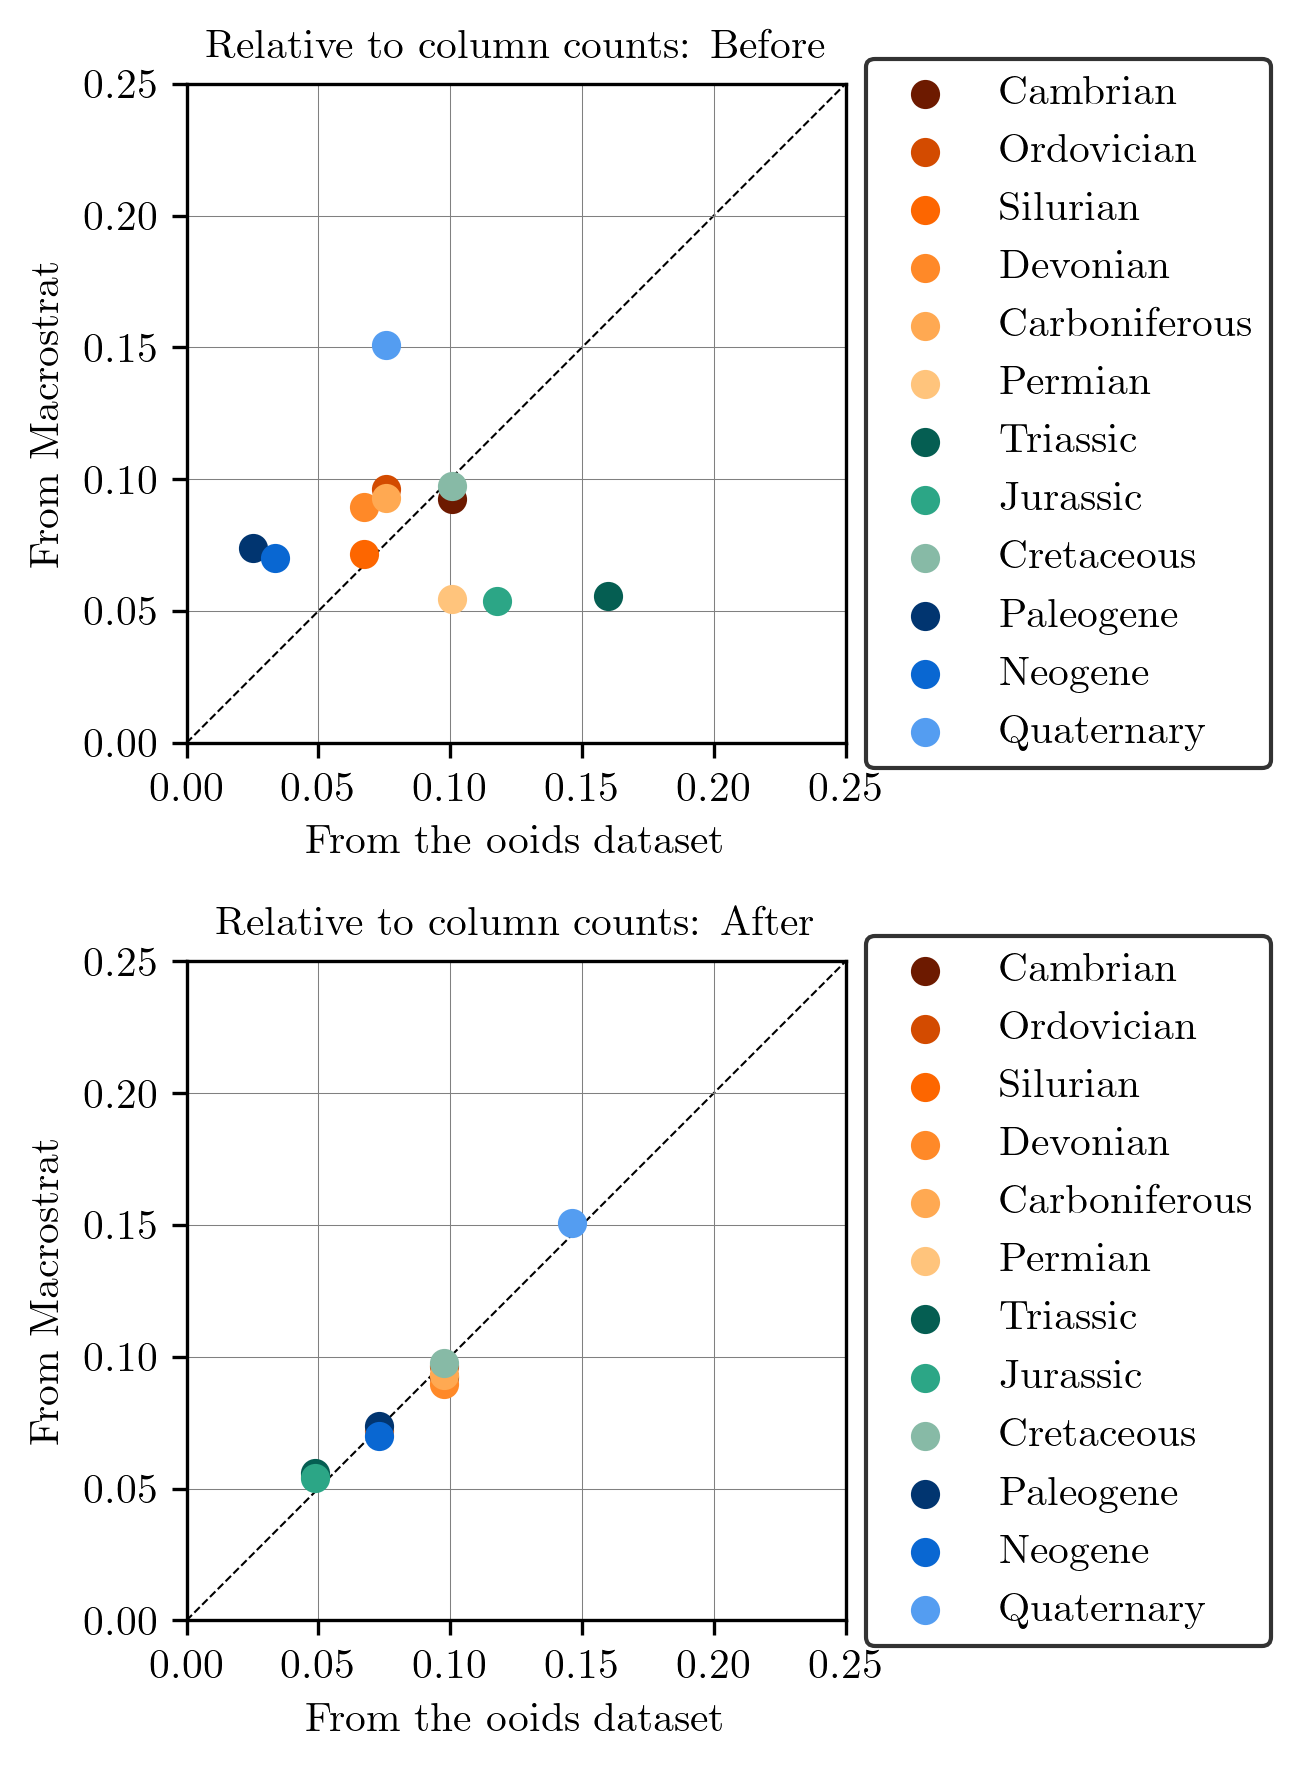

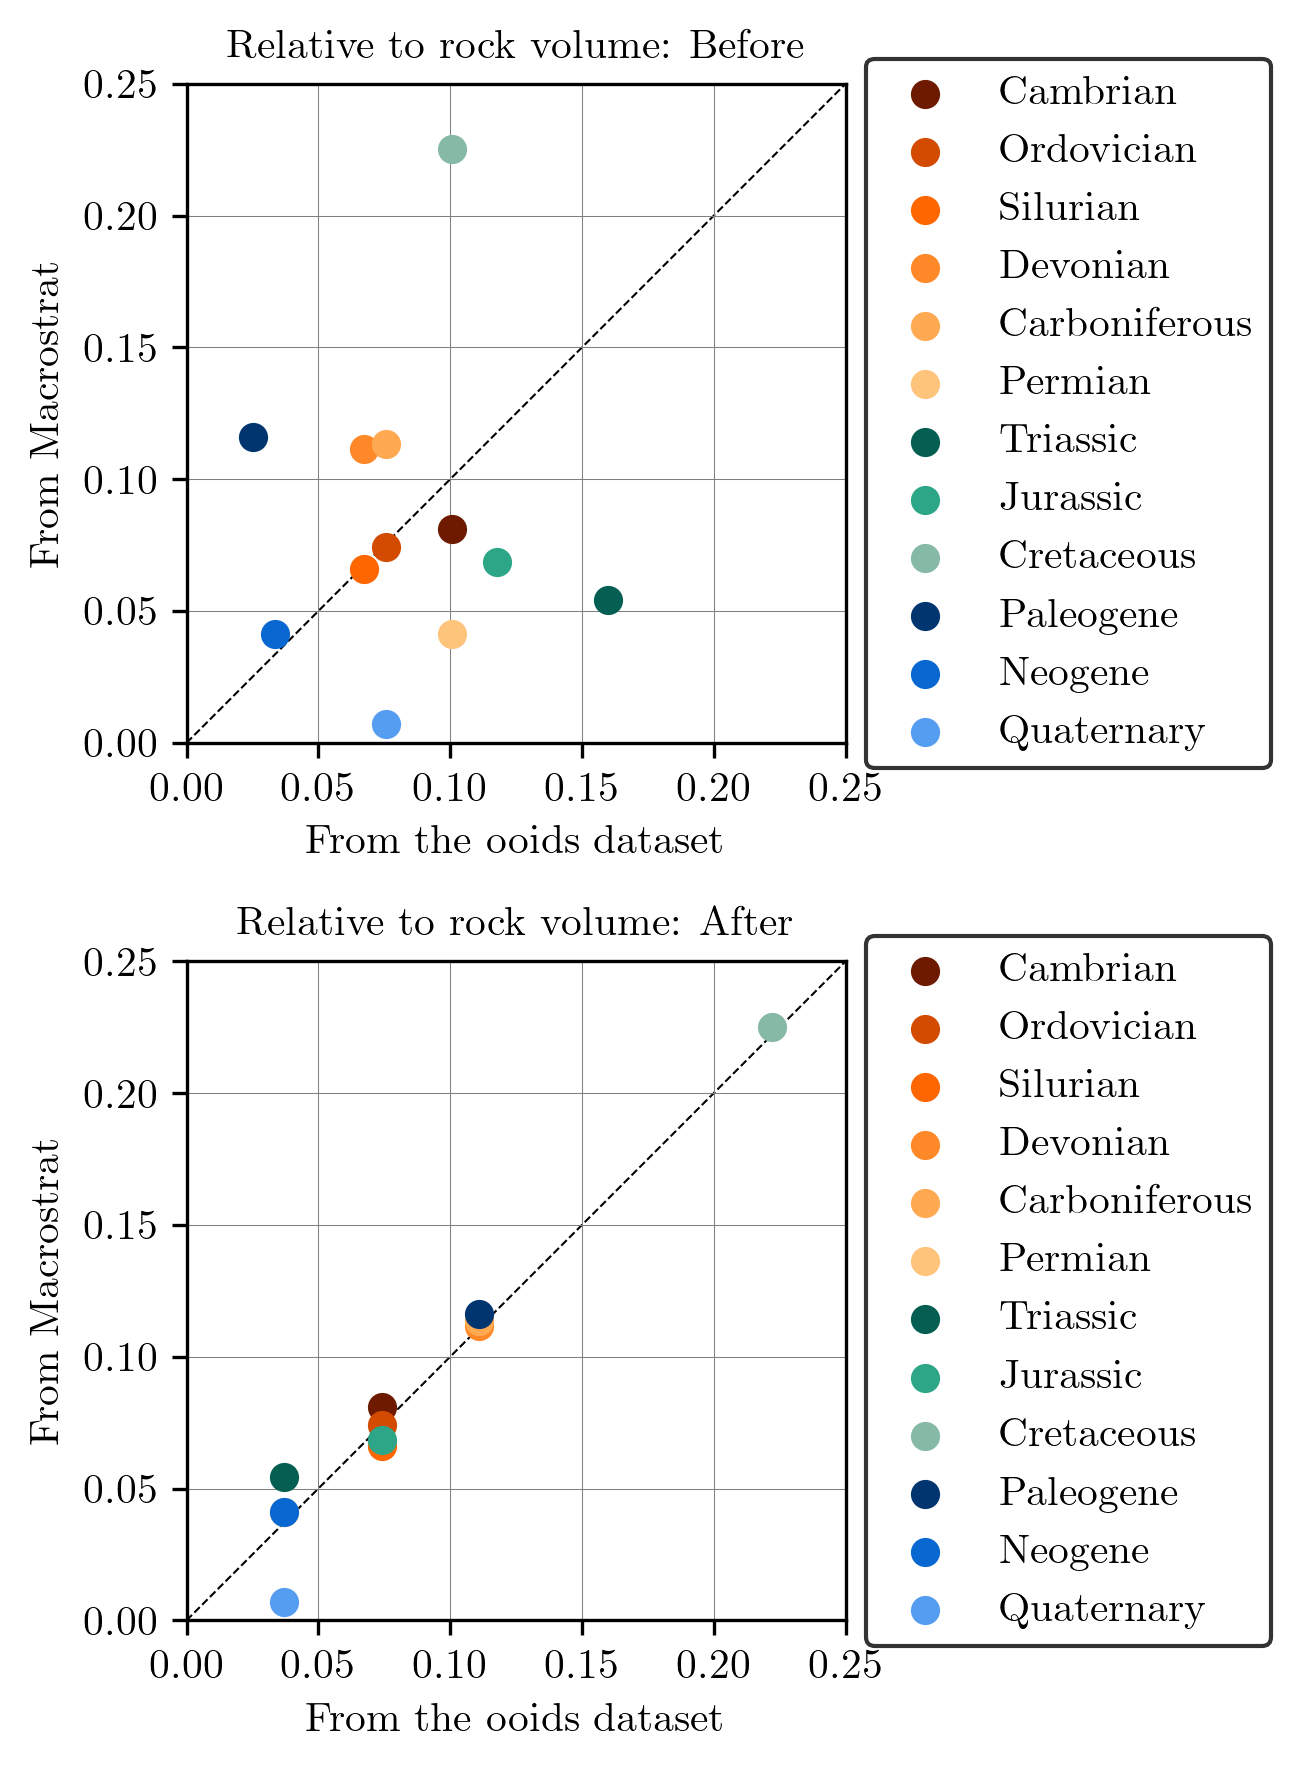

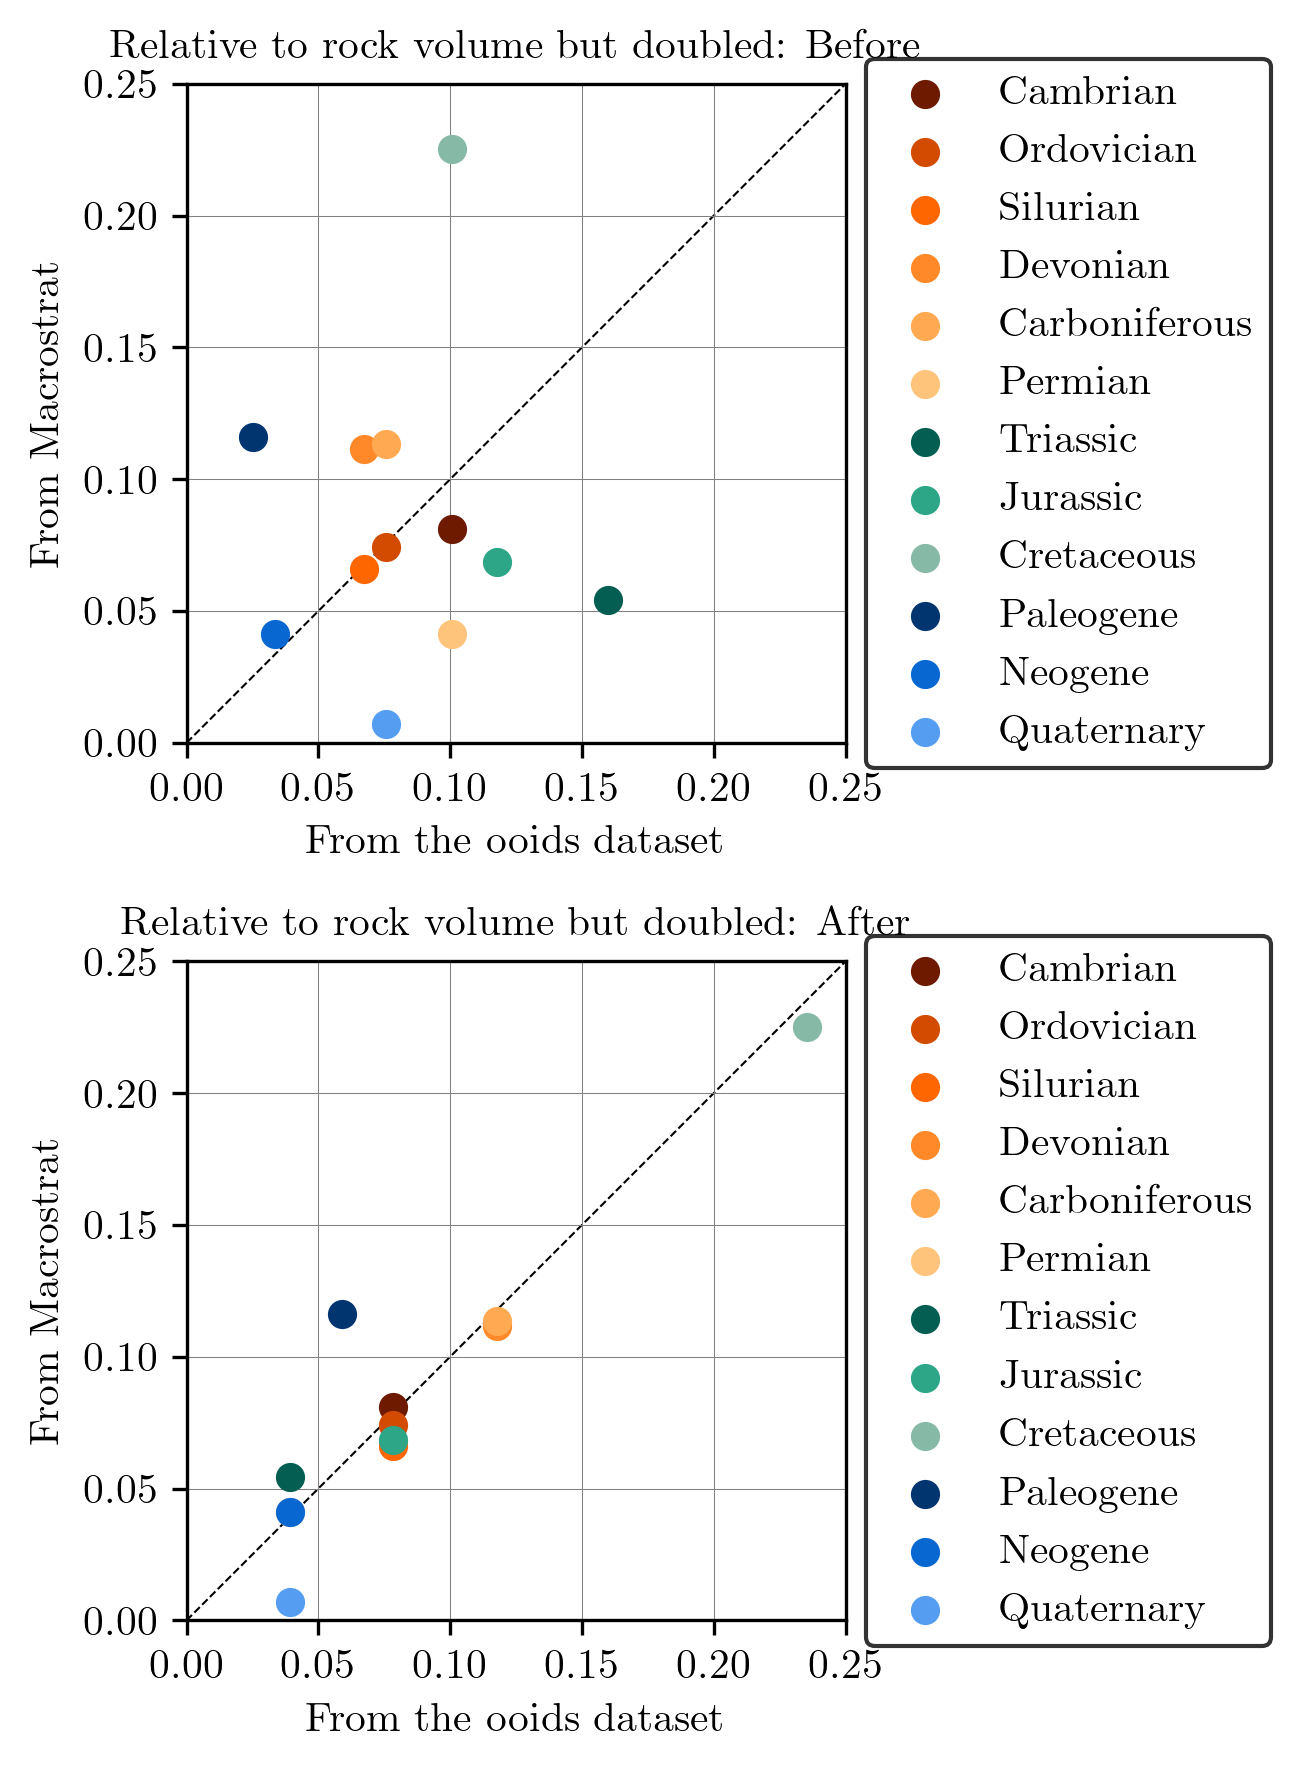

In [103]:
# O N  - P R O P O R T I O N S
# How well do our data reflect the expected proportions of rocks from each period?

# To start, we calculate relative proportion for locations from the ooids dataset
relativeProps = np.around(numLocations / np.sum(numLocations),4)


# Next, let's re-proportion the ooids database using both column and volume stats from MacroStrat
reProportionedVals = [reProportion([el["columnCount"] for el in msPerPeriodStats], numLocations), reProportion([el["totalVolume"] for el in msPerPeriodStats], numLocations)]
reproportionedDescriptions = ['w.r.t. macrostrat columns', 'w.r.t. macrostrat volumes']

# One more thing: let's look at rock volume but this time double the number of locations per period (taking the maximum number of actual locations wherever necessary)

doubled = reProportionedVals[1].copy()
doubled['locations'] = doubled['locations'] * 2
for itr, val in enumerate(doubled['locations']):
    if val > numLocations[itr]:
        doubled['locations'][itr] = numLocations[itr]
doubled['proportions'] = doubled['locations'] / np.sum(doubled['locations'])

# Add this dictionary to the reProportionedVals variable
reProportionedVals.append(doubled)
reproportionedDescriptions.append('w.r.t. macrostrat volume but doubled')

maxVal = 0.25

prefixTitles = ['Relative to column counts: ', 'Relative to rock volume: ', 'Relative to rock volume but doubled: ']

for idx, vals in enumerate(reProportionedVals):
    

    fig, axs = plt.subplots(2, 1, figsize = (4, 6), dpi = 300)
    for itr, period in enumerate([el["period"] for el in msPerPeriodStats]):
        axs[0].scatter(relativeProps[itr], vals['targetProportions'][itr], label=period, facecolor=colormap(itr/len(uniquePeriods)))
        axs[1].scatter(vals['proportions'][itr], vals['targetProportions'][itr], label=period, facecolor=colormap(itr/len(uniquePeriods)))
    
    titles = ["Before", "After"]

    for itr, ax in enumerate(axs):
        ax.plot(np.arange(0, maxVal+0.1, 0.1), np.arange(0, maxVal+0.1, 0.1), '--', color='black', linewidth=0.5, zorder=0)
        ax.set_aspect('equal')
        ax.set_xlim(0, maxVal)
        ax.set_ylim(0, maxVal)
        ax.set_ylabel('From Macrostrat')
        ax.set_xlabel('From the ooids dataset')
        ax.set_title(prefixTitles[idx] + titles[itr], size=fs)
        ax.grid(True, which = 'major', color = 'grey', linewidth = .25, axis = 'both')
        ax.set_axisbelow(True)
        ax.legend()
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), edgecolor='black')

    fig.tight_layout()

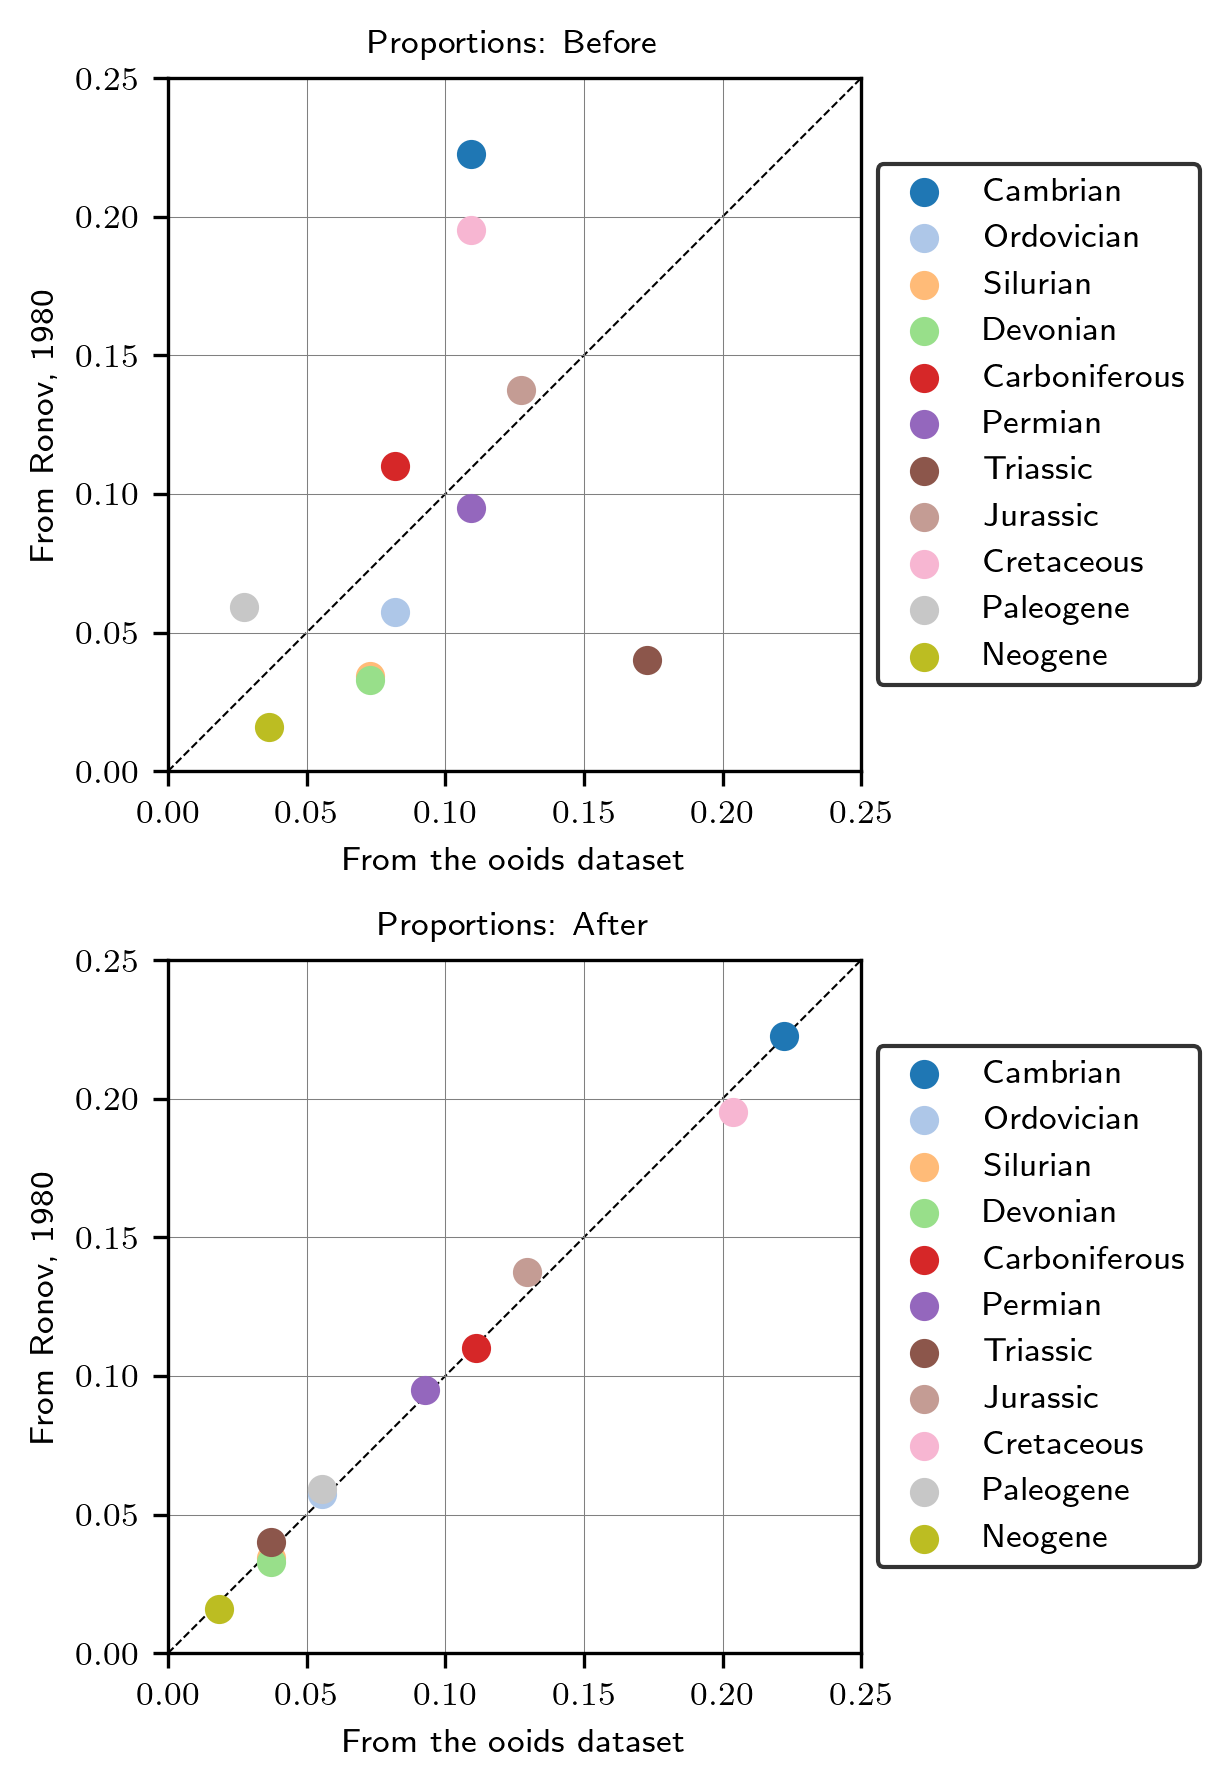

In [15]:
# W H A T  A B O U T  R O N O V ?
# We first load in the Ronov 1980 dataset
ronovData = csvToArray('Ronov1980.csv')
ronovData = makeValuesFloat(ronovData, ['vol_platform (10^6 km^3)', 'perc_carbonate'])
# Next, we want to group by period and calculate platform volume of carbonate
# We're going to modify uniquePeriods to ignore the Quaternary (it does not exist in Ronov)
modifiedPeriods = []
modifiedNumLocations = []
modifiedLocationNames = []
modifiedOoidsByPeriod = []
for itr, el in enumerate(uniquePeriods):
    if el != 'Quaternary':
        modifiedPeriods.append(el)
        modifiedNumLocations.append(numLocations[itr])
        modifiedLocationNames.append(locationNames[itr])
        modifiedOoidsByPeriod.append(ooidsByPeriod[itr])
modifiedRelativeProportions = modifiedNumLocations / np.sum(modifiedNumLocations)
carbonateVols = []
for thisPeriod in modifiedPeriods:
    # The period column contains this period 
    validRows = [el for el in ronovData if thisPeriod in el['period']]
    summedCarbonateVol = 0
    for row in validRows:
        thisCarbonateVol = row['vol_platform (10^6 km^3)'] * (row['perc_carbonate']/100)
        summedCarbonateVol = summedCarbonateVol + thisCarbonateVol
    carbonateVols.append(summedCarbonateVol)
relativeVols = carbonateVols / np.sum(carbonateVols)
# Re proportion?
toRonovVols = reProportion(relativeVols, modifiedNumLocations)
# Plot these outcomes up!
fig, axs = plt.subplots(2, 1, figsize = (4, 6), dpi = 300)
for itr, period in enumerate(modifiedPeriods):

    axs[0].scatter(modifiedRelativeProportions[itr], toRonovVols['targetProportions'][itr], label=period, facecolor=colormap(itr/len(uniquePeriods)))
    axs[1].scatter(toRonovVols['proportions'][itr], toRonovVols['targetProportions'][itr], label=period, facecolor=colormap(itr/len(uniquePeriods)))

titles = ["Before", "After"]

for itr, ax in enumerate(axs):
    ax.plot(np.arange(0, maxVal+0.1, 0.1), np.arange(0, maxVal+0.1, 0.1), '--', color='black', linewidth=0.5, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(0, maxVal)
    ax.set_ylim(0, maxVal)
    ax.set_ylabel('From Ronov, 1980')
    ax.set_xlabel('From the ooids dataset')
    ax.set_title('Proportions: ' + titles[itr], size=fs)
    ax.grid(True, which = 'major', color = 'grey', linewidth = .25, axis = 'both')
    ax.set_axisbelow(True)
    ax.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), edgecolor='black')

fig.tight_layout()

In [105]:
# W H A T  A B O U T  X D D?
# We first load in the XDD dataset
xddData = csvToArray('binned_xDD_ooids.csv')
# Make certain columns into floats
xddData = makeValuesFloat(xddData, ['age', 'num_ooids', 'all_carbonate'])

# Time to assign a period to each bin AND adjust counts
for el in xddData:
    # First, let's figure out and assign a geologic period to this entry
    thisPeriod = ' '.join(map(str, GTSPeriodNames[findCorrespondingPeriodIdx(GTSTopAges, GTSBottomAges, el['age'], el['age'])]))
    el.update({'period': thisPeriod});
    # Second, since num_ooids may include non-carbonate (e.g., iron) ooids, we need to ensure that num_ooids is never greater than all_carbonate (if num_ooids > all_carbonate, then num_ooids = all_carbonate)
    if el['num_ooids'] > el['all_carbonate']:
        el['num_ooids'] = el['all_carbonate']

# Now, let us create a new array of dicts, in which every entry contains a period, a sum of ooid containing entries, the total amount of carbonate, and the % of carbonate that contain ooids

xddPercents = []

for thisPeriod in uniquePeriods:
    # sum of num_ooids and all_carboante for this period
    sumAllOoids = 0
    sumAllCarbonates = 0
    for entry in xddData:
        if entry['period'] == thisPeriod:
            sumAllOoids = sumAllOoids + entry['num_ooids']
            sumAllCarbonates = sumAllCarbonates + entry['all_carbonate']
    # Now, let's calculate a % of carbonate that have ooids
    percentCarbsOoids = (sumAllOoids / sumAllCarbonates) * 100
    # Finally, we use Bolton's normalization method
    alternateNorm = sumAllCarbonates * (sumAllOoids / sumAllCarbonates)
    # Store it all
    xddPercents.append({'period': thisPeriod, 'sumOoids': sumAllOoids, 'sumCarbonates': sumAllCarbonates, 'percentOoids': percentCarbsOoids, 'alternateNorm': alternateNorm})

# Assuming that % of carbonates that are ooids tell us something about the underlying abundance of ooids through time, what are the relative proportions per period?

for el in xddPercents:
    el.update({'pctProportion': el['percentOoids'] / np.sum([el['percentOoids'] for el in xddPercents])})
    el.update({'alternateProportion': el['alternateNorm'] / np.sum([el['alternateNorm'] for el in xddPercents])})

#Finally, let us re-proportion the data relative to xDD

xDDReproportioned = reProportion([el['alternateProportion'] for el in xddPercents], numLocations)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


R-squared: 0.614195
p value: 0.002559


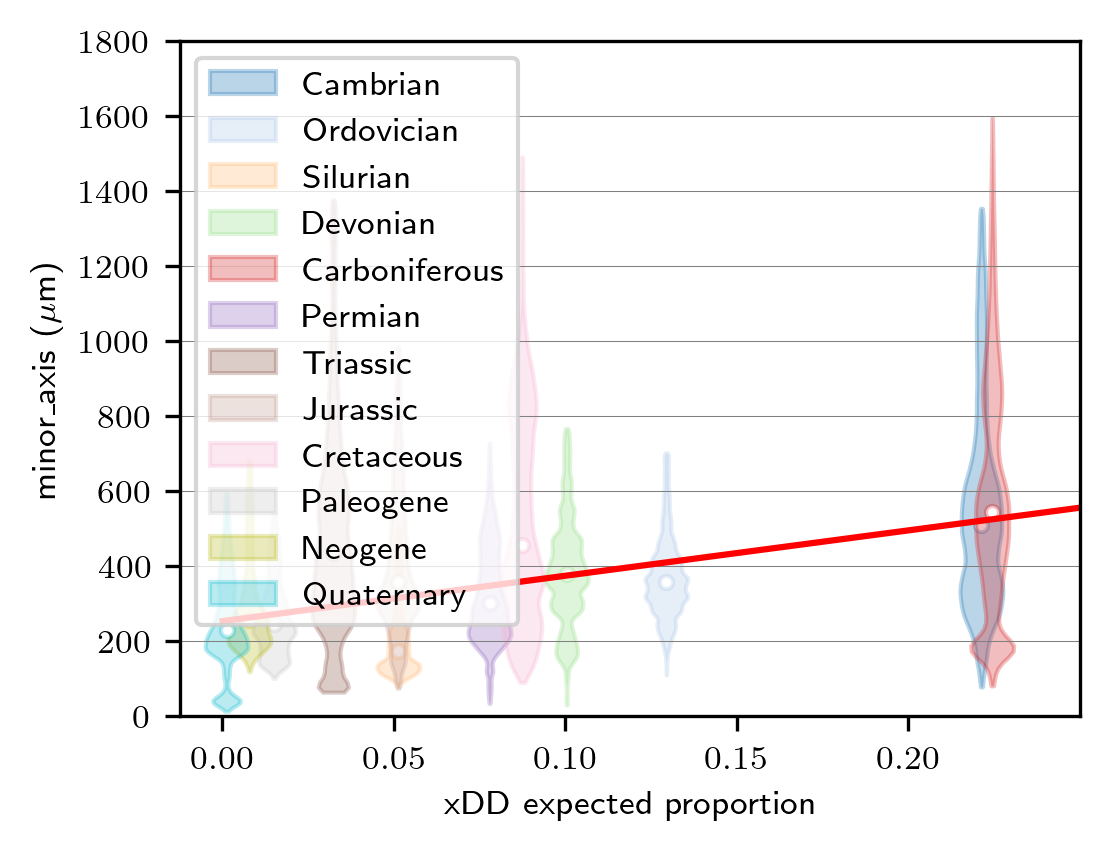

In [52]:
def plotSizeDataVsProportions(sizeData, targetProportions, timePeriods):
    
    medians = list(map(np.median, sizeData))
    thisAx = violinPlot(sizeData, targetProportions, timePeriods, medians, 0.0125)
    # Simple regression
    res = stats.linregress(targetProportions, medians)
    returnRegressionStats(res)
    # Plot this line
    locationArray = np.linspace(0, np.max(targetProportions) * 2)
    thisAx.plot(locationArray, res.intercept + res.slope*locationArray, 'r', label='fitted line')
    return thisAx

thisAx = plotSizeDataVsProportions(removeOutliersIQR(ooidsByPeriod), [el['alternateProportion'] for el in xddPercents], uniquePeriods)
plt.tight_layout()
plt.subplots_adjust(left=.125, bottom=.125, right=.875, top=.875)
thisAx.set_xlim(-0.0125, 0.25)
thisAx.set_xticks(np.arange(0, 0.25, 0.05))
thisAx.set_ylim(0, 1800)
thisAx.set_ylabel(whichAxis + ' ($\mu$m)')
thisAx.set_xlabel('xDD expected proportion')

plt.savefig('ooidSizeVsxDDProportions.eps', format='eps')

/var/folders/lw/rvmwpzkd3sz_g7cf1kjr3fv40000gn/T/ipykernel_85260/747926703.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/lw/rvmwpzkd3sz_g7cf1kjr3fv40000gn/T/ipykernel_85260/747926703.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


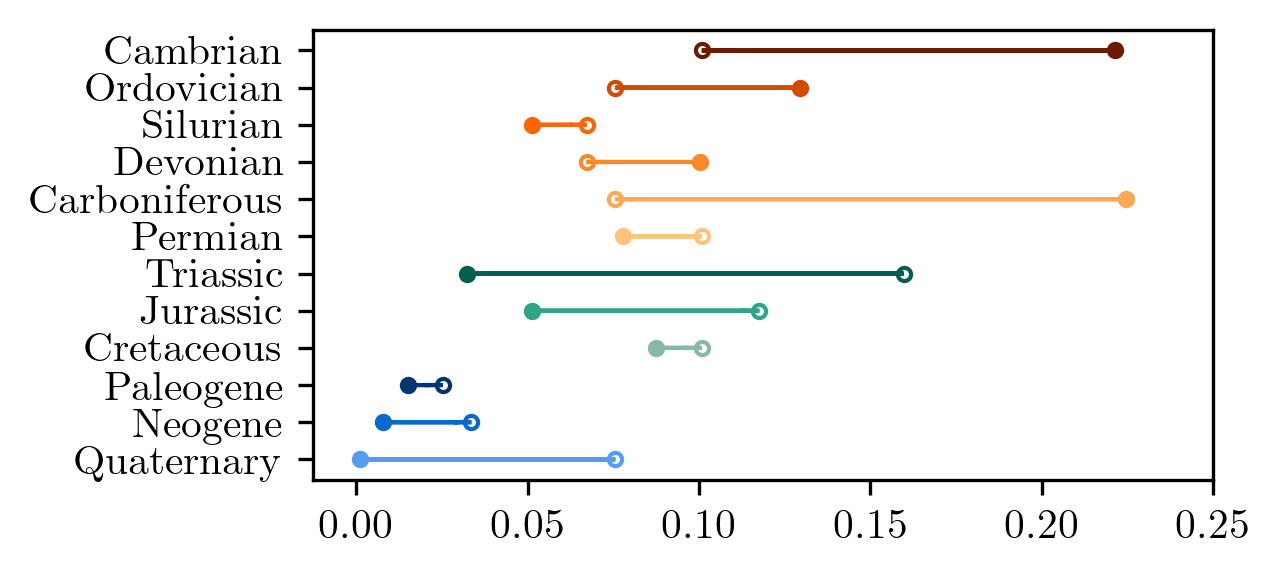

In [245]:

def shiftFromOriginalToTarget(originalProportions, targetProportions, timePeriods, colormap):
    fig = plt.figure(figsize = (4, 2), dpi = 300)
    ax = fig.add_axes([0.125, 0.125, 0.75, 0.75])
    position = len(timePeriods)
    ax.set_yticks(np.linspace(1, position, position))
    for itr, period in enumerate(timePeriods):
        thisColor = colormap(itr/len(timePeriods))
        ax.scatter(targetProportions[itr], position, fc=thisColor, s=10)
        ax.scatter(originalProportions[itr], position, fc='white', ec=thisColor, s=10)
        ax.arrow(targetProportions[itr], position, originalProportions[itr] - targetProportions[itr], 0, ec=thisColor, length_includes_head=True) 
        # ax.annotate("", xy=(targetProportions[itr], position), xytext=(originalProportions[itr], position),  arrowprops=dict  (arrowstyle="->", lw=.5))
        position = position - 1
    ax.set_yticklabels(timePeriods[::-1])
    fig.tight_layout()
    ax.set_xlim(-0.0125, 0.25)
    # thisAx.set_xticks(np.arange(0, 0.25, 0.05))
    
    return ax
    
thisAx = shiftFromOriginalToTarget(relativeProps, [el['alternateProportion'] for el in xddPercents], uniquePeriods, colormap)


    
plt.savefig('shiftInProportions.eps', format='eps')

[-0.25  0.75  1.75  2.75  3.75  4.75  5.75  6.75  7.75  8.75  9.75 10.75]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]


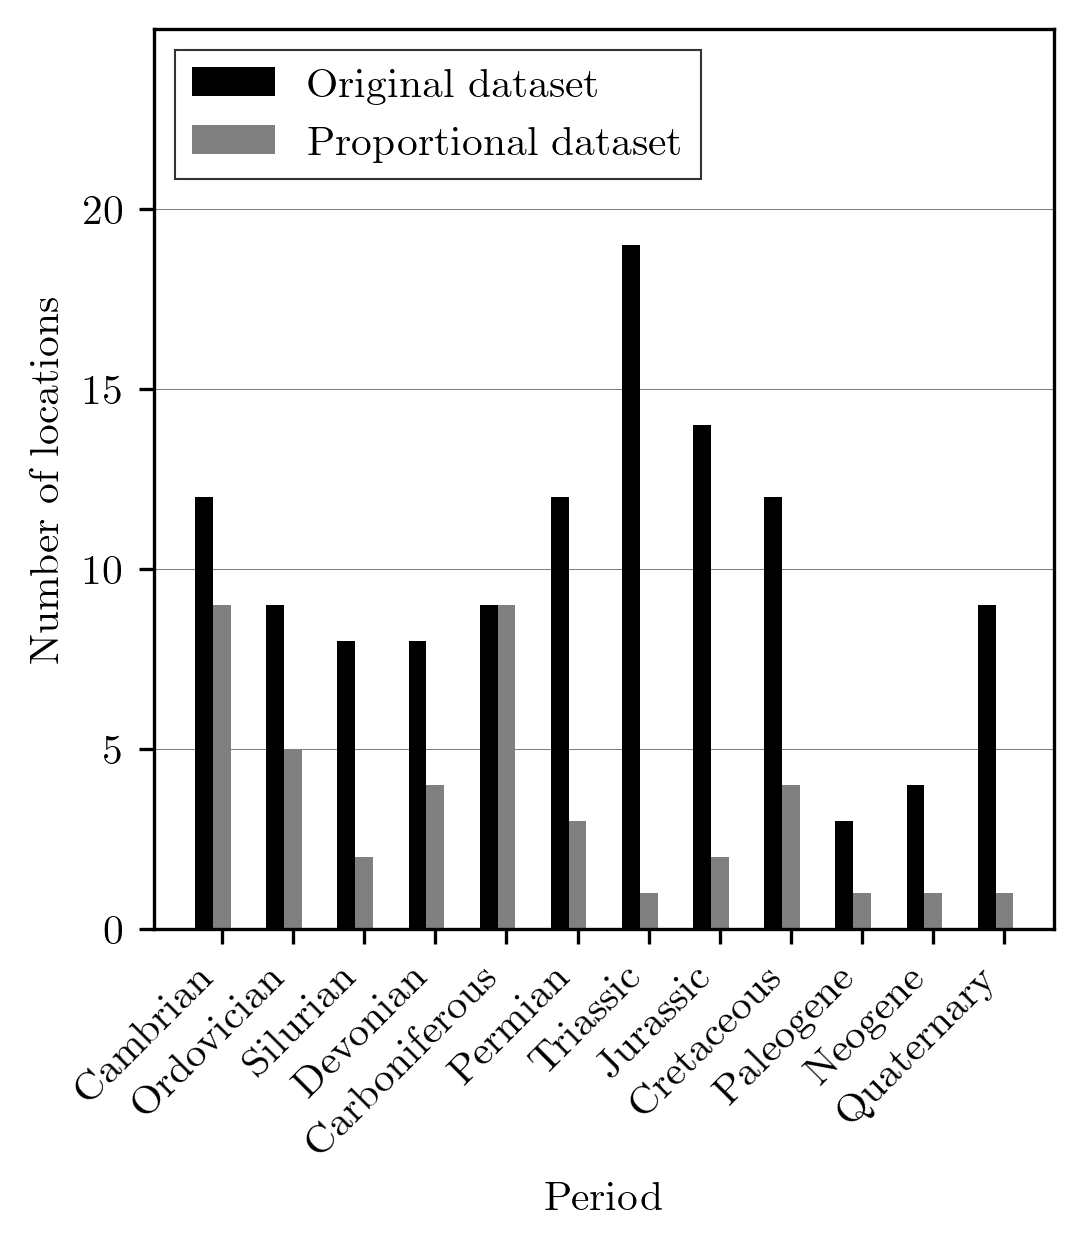

In [268]:
# P L O T T I N G - O U T C O M E S
# proportionedLocations = [numLocations, reProportionedVals[1]['locations'], reProportionedVals[2]['locations']]
proportionedLocations = [numLocations, xDDReproportioned['locations']]
numVersions = len(proportionedLocations)
baseWidth = .25
shift = np.asarray([-1, 0, 1]) * baseWidth
barColors = ['black', 'gray', 'orange']

fig, ax = plt.subplots(figsize = (4, 4), dpi = 300)

for itr, locs in enumerate(proportionedLocations):
    print(np.arange(len(locs)) + shift[itr])
    ax.bar(np.arange(len(locs))+ shift[itr], locs, baseWidth, color=barColors[itr])
    if itr == 0:
        ax.set_xticks(np.arange(len(locs)))
        ax.set_xticklabels(uniquePeriods, rotation=45, ha='right')

ax.set_ylim(0, 25)
ax.set_yticks(np.arange(0, 25, 5))
ax.grid(True, which = 'major', color = 'grey', linewidth = .25, axis = 'y')
ax.set_axisbelow(True)
ax.set_xlabel('Period')
ax.set_ylabel('Number of locations')
legend = ax.legend(['Original dataset', 'Proportional dataset'], loc='upper left', bbox_to_anchor=(0, 1), edgecolor='black', fancybox=False)
legendFrame = legend.get_frame()
legendFrame.set_linewidth(0.5)

plt.tight_layout()
plt.subplots_adjust(left=.125, bottom=.25, right=.875, top=1)

fig.savefig('../figures/proportioningCounts.pdf')

In [65]:
# S C E N A R I O 
# N O . 
# 2
# What if we only worked with datasets that were in proportion to rock volume?

numberNewDatasets = 1000

# proportionalSetToUse = reProportionedVals[1]
proportionalSetToUse = xDDReproportioned

counts = []
r2Collector = []
pCollector = []
corrCollector = []
bestWorstRun = {"bestRunPValue": 1, "bestRunRValue": 0, "bestRunCorr": -1, "bestRunMedians": [], "worstRunPValue": 0, "worstRunRValue": 1, "worstRunCorr": 1, "worstRunMedians": []}

for instance in range(numberNewDatasets):
    newDataset = []
    # Okay, the way this will work is that we need to pick n locations from each period, where n is dictated by the proportional estimate
    locs = []
    # First, let's generate a list of locations per period
    for itr, count in enumerate(proportionalSetToUse['locations']):
        # Which locations are available to select from?
        toSelectFrom = locationNames[itr]
        numAvail = len(toSelectFrom)
        # Okay, draw, WITHOUT REPLACEMENT
        idxs = np.random.choice(numAvail, size=int(count), replace=False)
        chosenLocations = list(np.array(toSelectFrom)[idxs])
        for name in chosenLocations:
            locs.append(name)

    # Okay, let's go through the original dataset and only keep ooids that belong to the locations in locs
    newDataset = []
    for item in ooidsData:
        thisLocation = item['location']
        if any(thisLocation in el for el in locs):
            newDataset.append(item)
    # How many ooids in this new dataset?
    ooidsCount = len(newDataset)
    counts.append(ooidsCount)
    # Now, we resample...
    # We create an np array of mxn where cols are: age, axisMin, and axisMax
    toDrawFrom = createNPArray(newDataset, ['reportedAge', whichAxis, whichAxisPrefix + 'Max'])
    # We draw a new axis length for each ooid in the database
    newAxes = np.round(rng.uniform(low = toDrawFrom[:, 1], high = toDrawFrom[:, 2]),0)
    # Now, we group by period
    byPeriod, _, locCount, _ = clusterByPeriod(newDataset, newAxes, uniquePeriods)
    # We find the median values
    medianVals = list(map(np.median, byPeriod))
    # Finally, we calculate a fit through the median vs formationCount
    simpleRegression = stats.linregress(locCount, medianVals)
    thisR2Value = simpleRegression.rvalue**2
    thisPValue = simpleRegression.pvalue
    # And extract the correlation coefficient
    thisCorrCoeff = stats.pearsonr(locCount, medianVals).statistic
    # We store the r^2
    r2Collector.append(thisR2Value)
    # And the p values
    pCollector.append(thisPValue)
    # Also, a simple correlation coefficient 
    corrCollector.append(thisCorrCoeff)

    # Now, we decide whether this run is the best or worst 

    targetPValue = 0.05

    if (thisCorrCoeff > bestWorstRun["bestRunCorr"]) & (thisPValue <= targetPValue):
        bestWorstRun["bestRunRValue"] = thisR2Value
        bestWorstRun["bestRunPValue"] = thisPValue
        bestWorstRun["bestRunCorr"] = thisCorrCoeff
        bestWorstRun["bestRunMedians"] = medianVals
    
    if (thisCorrCoeff < bestWorstRun["worstRunCorr"]) & (thisPValue <= targetPValue):
        bestWorstRun["worstRunRValue"] = thisR2Value
        bestWorstRun["worstRunPValue"] = thisPValue
        bestWorstRun["worstRunCorr"] = thisCorrCoeff
        bestWorstRun["worstRunMedians"] = medianVals

    # print('The original dataset had ' + str(len(ooidsData)) + ' elements. The new dataset has ' + str(len(newDataset)) + ' elements.')

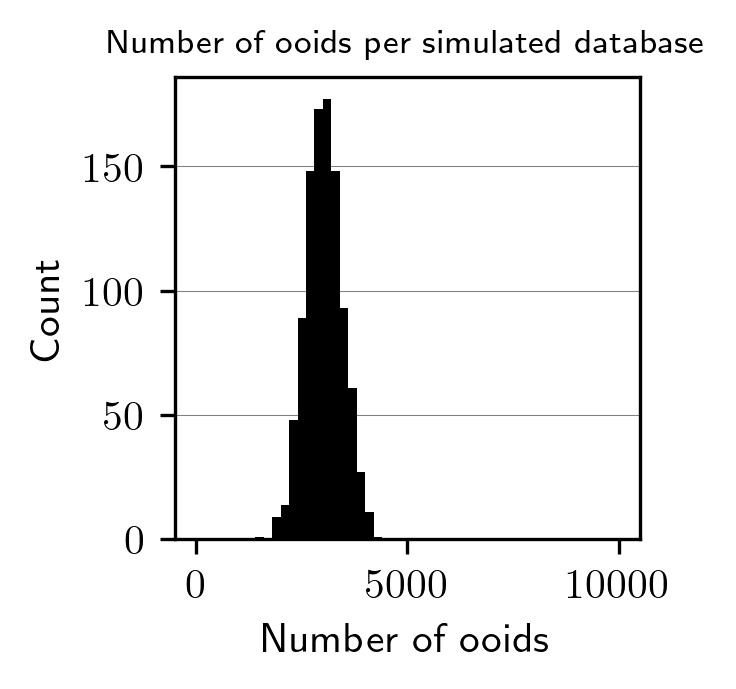

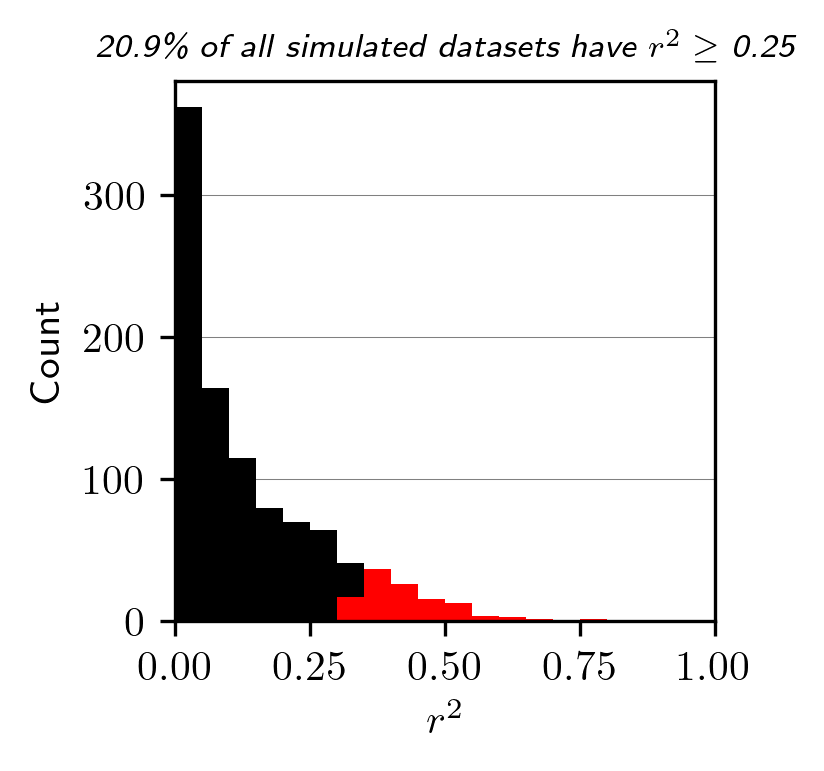

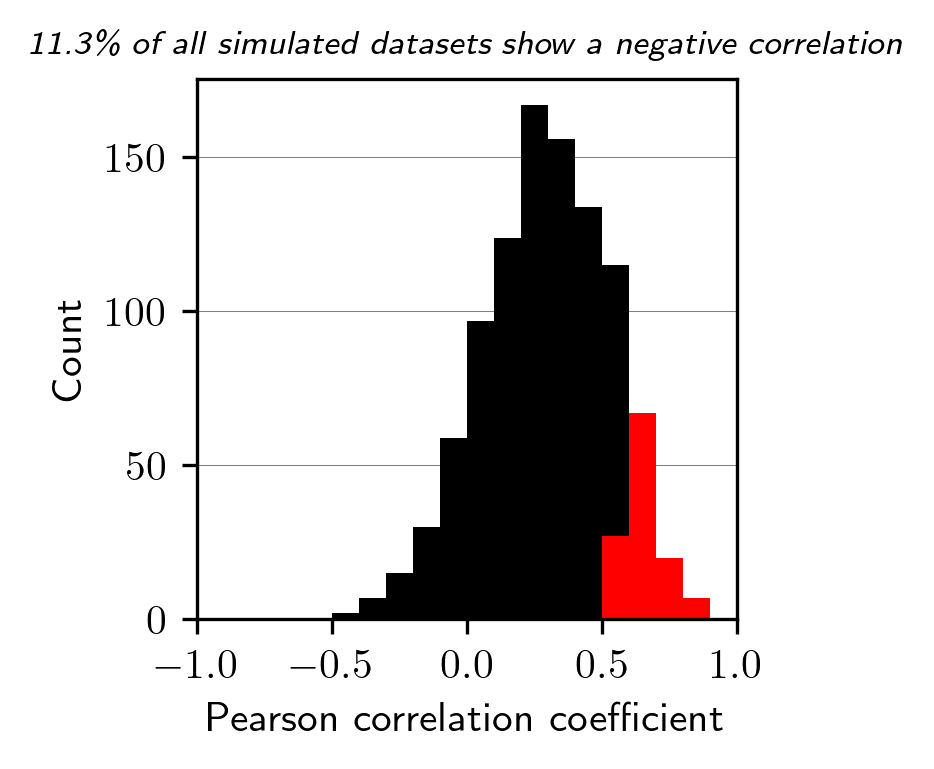

In [157]:
fig, ax = plt.subplots(figsize = (2, 2), dpi = 300)
ax.hist(counts, facecolor = 'black', bins=50, range=(0, 10000));
ax.set_title('Number of ooids per simulated database', fontsize=fs)
ax.set_xlabel('Number of ooids')
ax.set_ylabel('Count')
ax.grid(True, which = 'major', color = 'grey', linewidth = .25, axis = 'y')
ax.set_axisbelow(True)

fig, ax = plt.subplots(figsize = (3, 3), dpi = 300)
highPR2 = [i for i, j in zip(r2Collector, pCollector) if j <= 0.05]
ax.hist(r2Collector, facecolor = 'black', bins=20, range=(0, 1));
ax.hist(highPR2, facecolor = 'red', bins=20, range=(0, 1));
ax.set_ylabel('Count')
ax.set_xlabel('$r^2$')
ax.set_xlim(0,1)
ax.set_title('\\textit{' + str(np.around(len([val for val in r2Collector if val >= 0.25]) / numberNewDatasets * 100, 3)) + '\% of all simulated datasets have $r^2 \geq$ 0.25}', fontsize=fs)
ax.grid(True, which = 'major', color = 'grey', linewidth = .25, axis = 'y')
ax.set_axisbelow(True)
plt.tight_layout(pad=0) # Adjust the spacing of the subplots
fig.subplots_adjust(left=0.2, bottom=0.2, right=0.8, top=0.8, wspace=None, hspace=None)

plt.savefig("r2.pdf")



fig, ax = plt.subplots(figsize = (3, 3), dpi = 300)
# Here, we go ahead and we only find correlations with decent p values (cut off being 0.10)
highPCorr = [i for i, j in zip(corrCollector, pCollector) if j <= 0.05]
ax.hist(corrCollector, facecolor = 'black', bins=20, range=(-1, 1));
ax.hist(highPCorr, facecolor = 'red', bins=20, range=(-1, 1));
ax.set_ylabel('Count')
ax.set_xlabel('Pearson correlation coefficient')
ax.set_xlim(-1, 1)
ax.set_title('\\textit{' + str(len([val for val in corrCollector if val < 0]) / numberNewDatasets * 100) + '\% of all simulated datasets show a negative correlation', fontsize=fs)
ax.grid(True, which = 'major', color = 'grey', linewidth = .25, axis = 'y')
ax.set_axisbelow(True)
fig.subplots_adjust(left=0.2, bottom=0.2, right=0.8, top=0.8, wspace=None, hspace=None)
plt.savefig("corrCoeff.pdf", format="pdf")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


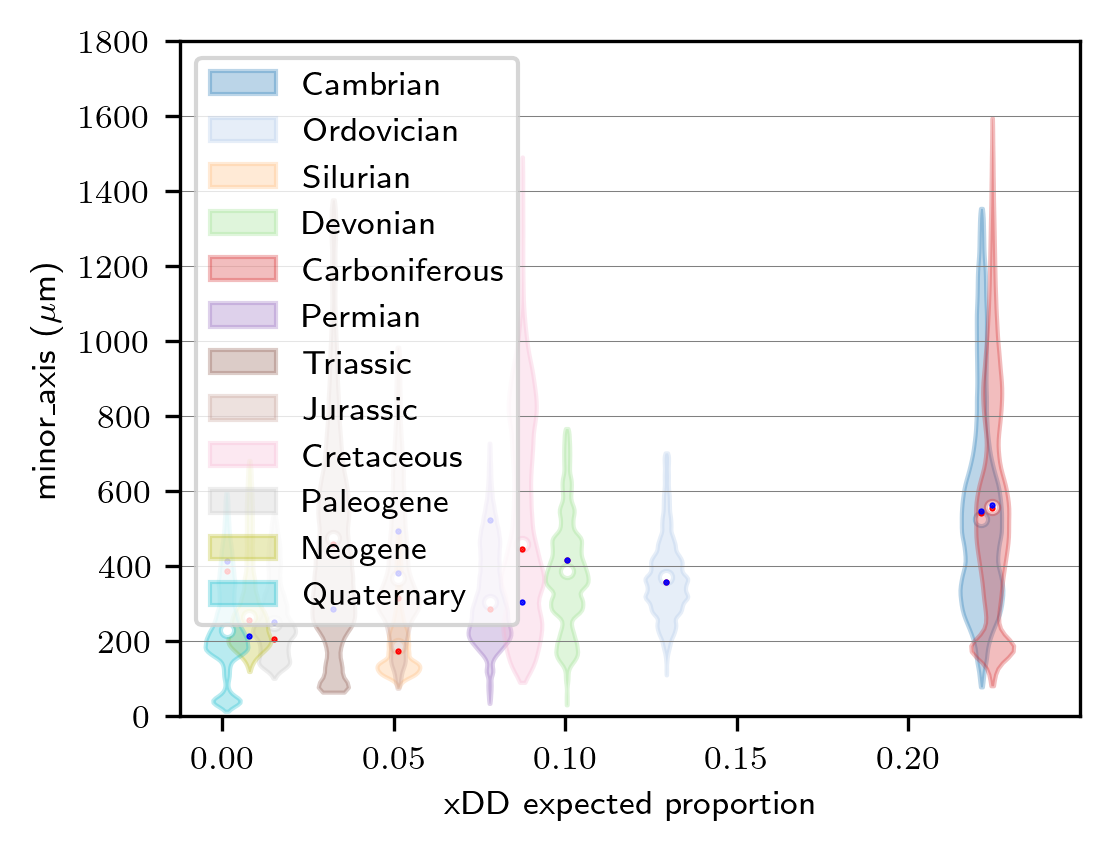

In [75]:
# Plot the best and worst case median outcomes on a violin plot

thisAx = violinPlot(removeOutliersIQR(ooidsByPeriod), [el['alternateProportion'] for el in xddPercents], uniquePeriods, list(map(np.median, ooidsByPeriod)), 0.0125)

plt.scatter([el['alternateProportion'] for el in xddPercents], bestWorstRun["bestRunMedians"], 0.25, 'r')
plt.scatter([el['alternateProportion'] for el in xddPercents], bestWorstRun["worstRunMedians"], 0.25, 'b')

plt.tight_layout()
plt.subplots_adjust(left=.125, bottom=.125, right=.875, top=.875)
thisAx.set_xlim(-0.0125, 0.25)
thisAx.set_xticks(np.arange(0, 0.25, 0.05))
thisAx.set_ylim(0, 1800)
thisAx.set_ylabel(whichAxis + ' ($\mu$m)')
thisAx.set_xlabel('xDD expected proportion')

plt.savefig('bestWorstCaseRuns.eps', format='eps')

In [67]:
print(bestWorstRun)

{'bestRunPValue': 6.794495190875433e-05, 'bestRunRValue': 0.809165402914015, 'bestRunCorr': 0.8995362154543944, 'bestRunMedians': [542.0, 358.0, 174.5, 417.0, 554.5, 286.0, 459.0, 315.0, 445.0, 206.0, 256.0, 387.0], 'worstRunPValue': 0.049433209307956597, 'worstRunRValue': 0.33309360272032923, 'worstRunCorr': 0.5771426190469121, 'worstRunMedians': [546.0, 357.0, 383.0, 417.0, 562.0, 524.0, 285.0, 494.5, 304.5, 250.0, 214.0, 413.5]}


In [76]:
# O P T I O N A L - S A V E - S T A T E

# get the current state of the bit generator
# state = rng.bit_generator.state

# save the state to a file
# np.save("seed.npy", state)

In [106]:
import matplotlib.font_manager as font_manager

font_manager.findfont('IBM Plex Sans')

findfont: Font family ['IBM Plex Sans'] not found. Falling back to DejaVu Sans.


'/opt/homebrew/anaconda3/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'